# Web Scraping

In [253]:
#selenium is a tool for automatic web browser interaction such as extracting data from websites

In [1]:
pip install selenium 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.


## Scraping NASA Exoplanet Watch Results Data

In [116]:
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [117]:
#when scraping the website noramlly, we noticed the result had some javascript
#and ajax which lead us to believe that the webpage was dynamically loaded
#thus we used selenium
from selenium import webdriver #module that controls web browsers
from selenium.webdriver.common.by import By #class to locate webpage elements
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC #wait for specific conditions to be met before proceeding

# Creating a new instance of the Chrome driver
driver = webdriver.Chrome()


url = "https://exoplanets.nasa.gov/exoplanet-watch/results/"
driver.get(url) # Navigating to the URL

# since the webpage loads the content and elements we need dynamically,
# we want to wait for the content to completely load before scraping
wait = WebDriverWait(driver, 10) #timout for 10 seconds
table = wait.until(EC.presence_of_element_located((By.TAG_NAME, "table")))# wait until the element 'table' is located on the page
# if the table is not found within 10 seconds, a TimeoutException will occur

# since the table is now a WebElement object, we can't use 'find_all()' 
#insted, we will use find_elements()

# Getting the table headers
headers = [header.text for header in table.find_elements(By.TAG_NAME, "th")]

# filling the table rows
rows = []
for row in table.find_elements(By.TAG_NAME, "tr"):
    cells = [cell.text for cell in row.find_elements(By.TAG_NAME, "td")]
    rows.append(cells)

# Printing the table data
print("Headers:", headers)
for row in rows:
    print(row)

# Close the browser
driver.quit()

Headers: ['Planet Name', 'Host Star Metallicity', 'Host Star log(g)', 'Host Star Radius [R_Sun]', 'Host Star Effective Temperature [K]', 'a/Rs', 'eccentricity', 'inclination [degrees]', 'omega [degrees]', 'orbital period [days]', 'Rp [R_Earth]', 'Rp/Rs', 'ephemeris [JD]']
[]
['CoRoT-1 b', '0.06', '4.33', '1.29', '5950.0', '4.8239', '0.036', '85.1', '0.0', '1.50896877', '20.59', '0.1146', '2456268.99119']
['CoRoT-2 b', '0.03', '4.42', '0.9', '5696.0', '6.7', '0.0', '87.84', '102.0', '1.74299705', '15.85', '0.1795', '2457683.44158']
['CoRoT-5 b', '-0.25', '4.34', '1.11', '6100.0', '9.54', '0.087', '85.68', '-128.34', '4.0379156', '14.08', '0.1235', '2456665.4696']
['CoRoT-7 b', '0.03', '4.54', '0.84', '5250.0', '4.26', '0.0', '80.98', '160.0', '0.8535', '1.524', '0.0187', '2454398.07756']
['CoRoT-8 b', '0.3', '4.58', '0.8', '5080.0', '13.7', '0.19', '88.18', '0.0', '6.212445', '6.94', '0.0807', '2454239.03317']
['CoRoT-11 b', '-0.03', '4.22', '1.37', '6440.0', '6.89', '0.36', '83.17', '0

In [118]:
type(table)

selenium.webdriver.remote.webelement.WebElement

In [119]:
exoWatchDF = pd.DataFrame(rows, columns=headers)
exoWatchDF = exoWatchDF.drop(columns = ['Host Star Metallicity', 'Host Star log(g)', 'Host Star Radius [R_Sun]', 
                                        'Host Star Effective Temperature [K]', 'eccentricity', 'orbital period [days]'])
exoWatchDF = exoWatchDF.rename(columns={"Planet Name" : "PlanetName", "inclination [degrees]" : "Inclination" , 
                                        "omega [degrees]":"Omega", "ephemeris [JD]":"Ephemeris", "Rp [R_Earth]":"Rp"})
exoWatchDF.head()

,PlanetName,a/Rs,Inclination,Omega,Rp,Rp/Rs,Ephemeris
0,None,None,None,None,None,None,None
1,CoRoT-1 b,4.8239,85.1,0.0,20.59,0.1146,2456268.99119
2,CoRoT-2 b,6.7,87.84,102.0,15.85,0.1795,2457683.44158
3,CoRoT-5 b,9.54,85.68,-128.34,14.08,0.1235,2456665.4696
4,CoRoT-7 b,4.26,80.98,160.0,1.524,0.0187,2454398.07756


# Cleaning the scraped data

In [120]:
#drop the first empty row
exoWatchDF.drop(exoWatchDF.index[0], inplace=True) #modify the dataframe itself

exoWatchDF.head() #show

,PlanetName,a/Rs,Inclination,Omega,Rp,Rp/Rs,Ephemeris
1,CoRoT-1 b,4.8239,85.1,0.0,20.59,0.1146,2456268.99119
2,CoRoT-2 b,6.7,87.84,102.0,15.85,0.1795,2457683.44158
3,CoRoT-5 b,9.54,85.68,-128.34,14.08,0.1235,2456665.4696
4,CoRoT-7 b,4.26,80.98,160.0,1.524,0.0187,2454398.07756
5,CoRoT-8 b,13.7,88.18,0.0,6.94,0.0807,2454239.03317


In [121]:
exoWatchDF.shape

(426, 7)

In [122]:
exoWatchDF.dtypes

PlanetName     object
a/Rs           object
Inclination    object
Omega          object
Rp             object
Rp/Rs          object
Ephemeris      object
dtype: object

## Handling null values

In [123]:
# handle empty strings to be able to convert values from objects to float
# empty strings are converted to NaN
exoWatchDF['a/Rs'] = pd.to_numeric(exoWatchDF['a/Rs'], errors='coerce').astype(float)
exoWatchDF['Inclination'] = pd.to_numeric(exoWatchDF['Inclination'], errors='coerce').astype(float)
exoWatchDF['Omega'] = pd.to_numeric(exoWatchDF['Omega'], errors='coerce').astype(float)
exoWatchDF['Rp'] = pd.to_numeric(exoWatchDF['Rp'], errors='coerce').astype(float)
exoWatchDF['Rp/Rs'] = pd.to_numeric(exoWatchDF['Rp/Rs'], errors='coerce').astype(float)
exoWatchDF['Ephemeris'] = pd.to_numeric(exoWatchDF['Ephemeris'], errors='coerce').astype(float)

exoWatchDF.dtypes

PlanetName      object
a/Rs           float64
Inclination    float64
Omega          float64
Rp             float64
Rp/Rs          float64
Ephemeris      float64
dtype: object

In [124]:
exoWatchDF.isnull().sum()

PlanetName     0
a/Rs           1
Inclination    0
Omega          0
Rp             0
Rp/Rs          0
Ephemeris      0
dtype: int64

<Axes: >

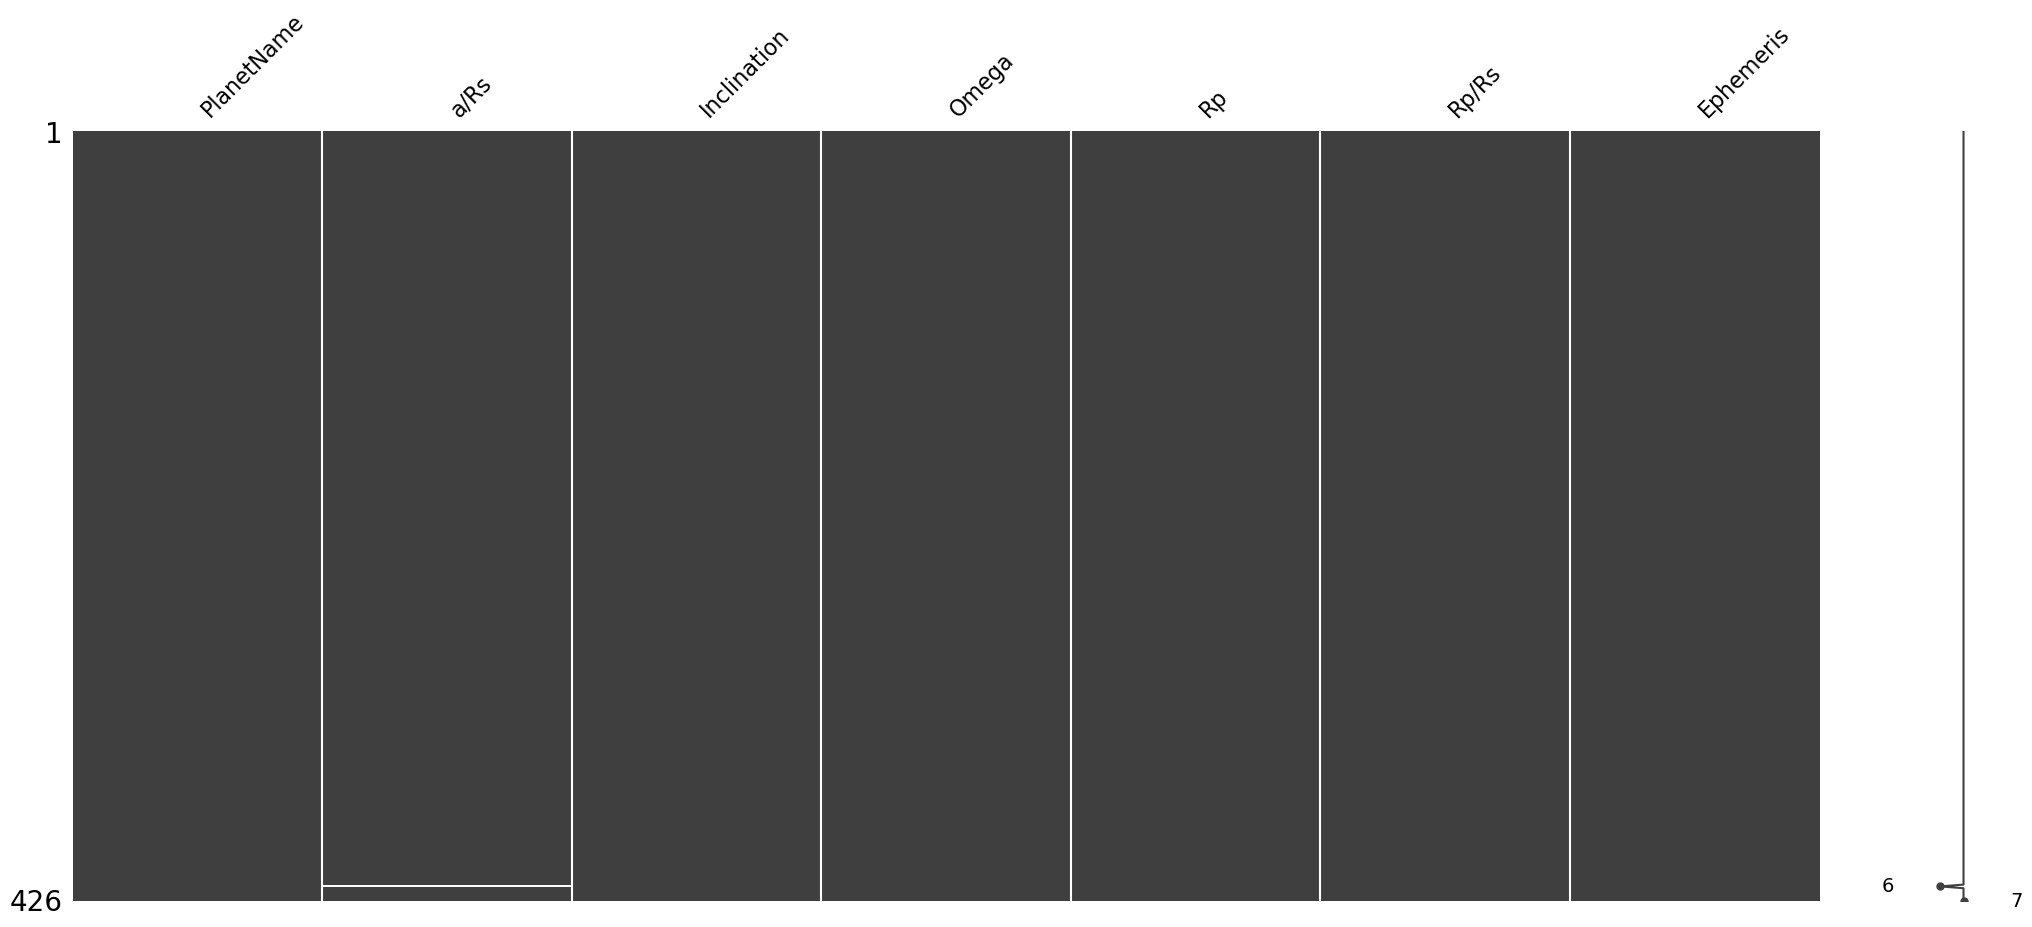

In [125]:
import missingno as msno 
msno.matrix(exoWatchDF) 

In [126]:
#Drop rows with empty values
exoWatchDF = exoWatchDF.dropna(subset=['a/Rs'],how='any')

<Axes: >

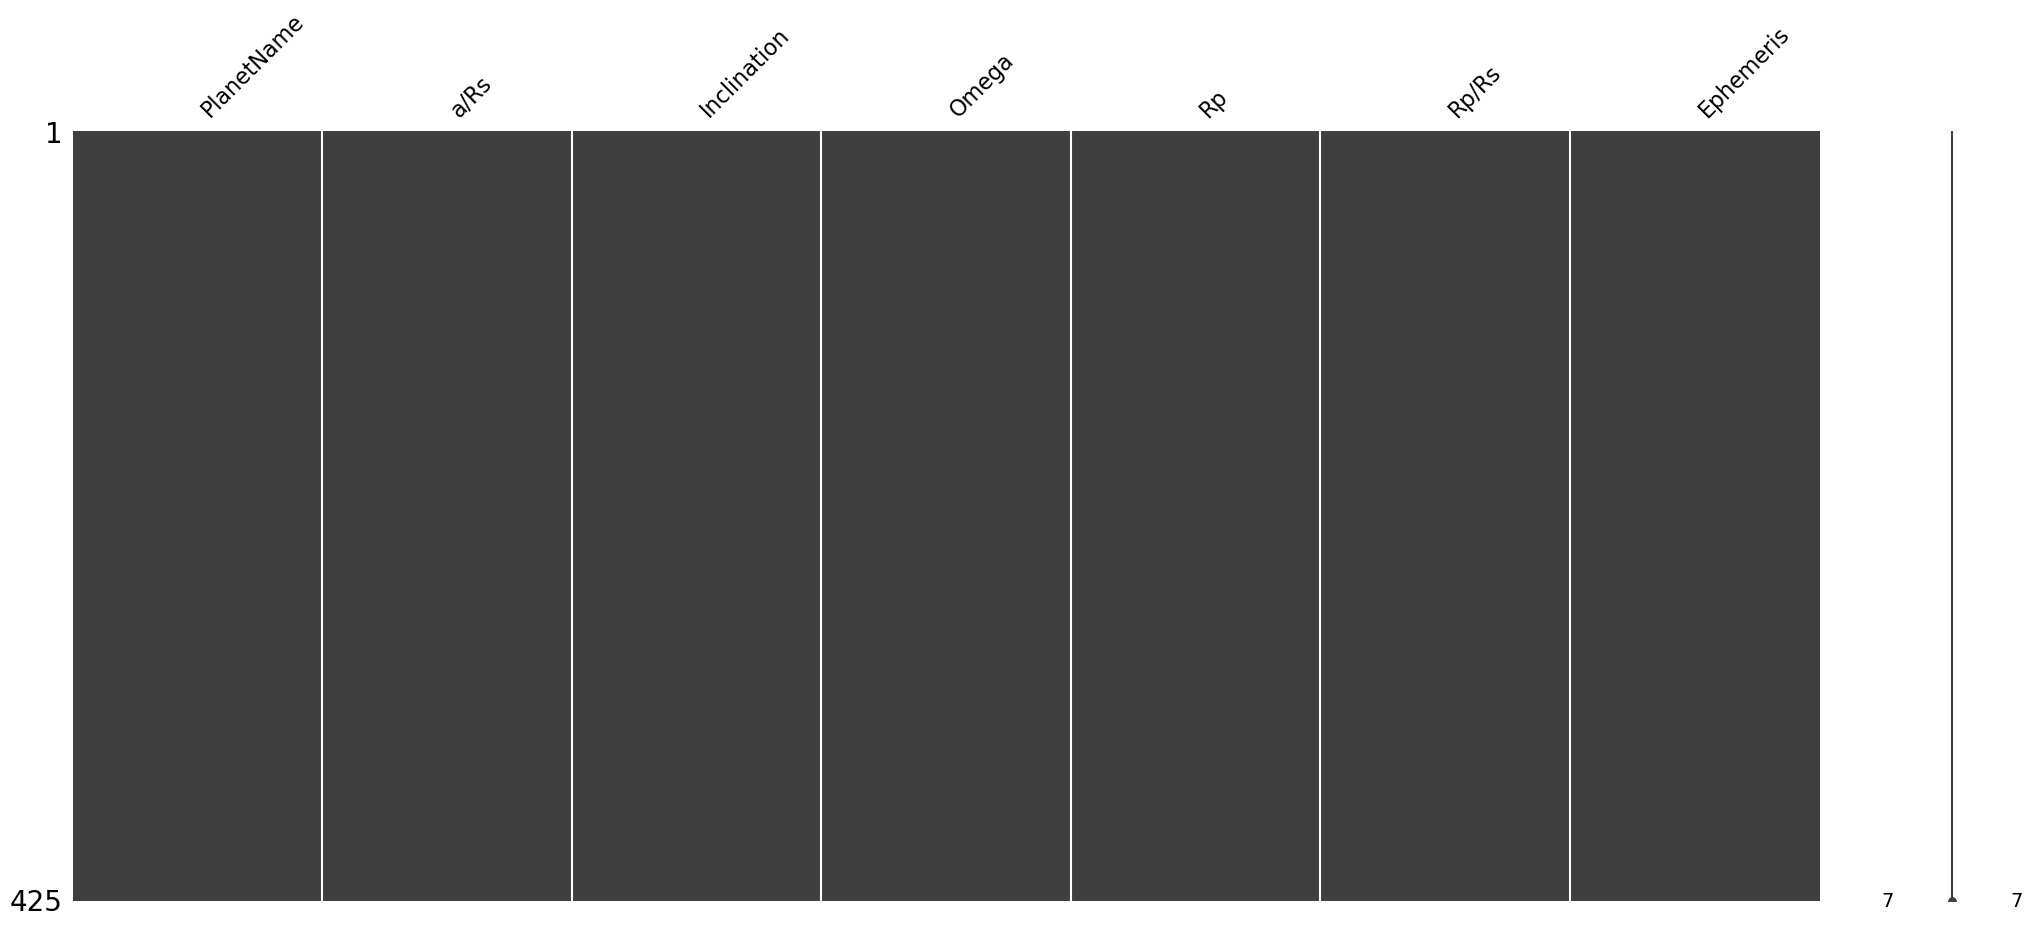

In [127]:
msno.matrix(exoWatchDF) 

In [128]:
# Remove duplicate rows based on repeated planet name
exoWatchDF = exoWatchDF.drop_duplicates(subset=["PlanetName"])
exoWatchDF.shape

(425, 7)

## Merge datasets

Some data loss occured in this phase due to merging as not all planets from our original dataset were present in the new scraped dataframe. 

In [129]:
#read the previous cleaned exoplanet data
exoplanets = pd.read_csv("ExoplanetsClean.csv")
exoplanetsdf=exoplanets[["PlanetName", "HostName", "NumOfStars", "NumOfPlanets", "DiscoveryMethod", "DiscoveryYear", "DiscoveryFacility", "ControversialFlag", "OrbitalPeriod", "OrbitSemi-MajorAxis", "Eccentricity", "EquilibriumTemperature", "StellarEffectiveTemperature", "StellarMetallicity", "StellarSurfaceGravity", "RightAscension", "Declination", "DistancetoPlanetarySystem", "StellarBrightnessGaia", "PlanetMass", "StellarMass", "PlanetRadiusKm", "StellarRadiusKm", "PlanetGravity", "StellarVolume", "StellarDensity"]]
exoplanetsdf.head()

,PlanetName,HostName,NumOfStars,NumOfPlanets,DiscoveryMethod,DiscoveryYear,DiscoveryFacility,ControversialFlag,OrbitalPeriod,OrbitSemi-MajorAxis,...,Declination,DistancetoPlanetarySystem,StellarBrightnessGaia,PlanetMass,StellarMass,PlanetRadiusKm,StellarRadiusKm,PlanetGravity,StellarVolume,StellarDensity
0,55 Cnc e,55 Cnc,2,5,Radial Velocity,2004,McDonald Observatory,0,0.736547,0.01544,...,28.329815,12.5855,5.72973,4.771948e+25,1.809535e+30,11945.625,653958.0,2.231946e+07,1.171489e+18,1.544645e+12
1,55 Cnc e,55 Cnc,2,5,Radial Velocity,2004,McDonald Observatory,0,0.736546,0.01583,...,28.329815,12.5855,5.72973,4.998899e+25,1.789650e+30,13844.183,667872.0,1.740786e+07,1.247867e+18,1.434167e+12
2,55 Cnc e,55 Cnc,2,5,Radial Velocity,2004,McDonald Observatory,0,0.736544,0.01544,...,28.329815,12.5855,5.72973,4.664444e+25,1.809535e+30,13251.680,653958.0,1.772816e+07,1.171489e+18,1.544645e+12
3,AU Mic b,AU Mic,1,3,Transit,2020,Transiting Exoplanet Survey Satellite (TESS),0,8.463080,0.06490,...,-31.342450,9.7221,7.84038,1.012508e+30,1.014135e+30,25210.047,514818.0,1.063303e+11,5.715441e+17,1.774377e+12
4,AU Mic c,AU Mic,1,3,Transit,2021,Transiting Exoplanet Survey Satellite (TESS),0,18.859690,0.11080,...,-31.342450,9.7221,7.84038,1.014545e+30,1.014135e+30,16067.662,514818.0,2.622840e+11,5.715441e+17,1.774377e+12


In [130]:
#merge all the common planet names between the two data sets
merged_df1 = pd.merge(exoWatchDF, exoplanetsdf, on="PlanetName", how="inner")
merged_df1.head()

,PlanetName,a/Rs,Inclination,Omega,Rp,Rp/Rs,Ephemeris,HostName,NumOfStars,NumOfPlanets,...,Declination,DistancetoPlanetarySystem,StellarBrightnessGaia,PlanetMass,StellarMass,PlanetRadiusKm,StellarRadiusKm,PlanetGravity,StellarVolume,StellarDensity
0,CoRoT-1 b,4.8239,85.10,0.00,20.590,0.1146,2.456269e+06,CoRoT-1,1,1,...,-3.102139,787.909,13.4570,1.955065e+27,1.889075e+30,106395.700,772227.0,1.152707e+07,1.928961e+18,9.793223e+11
1,CoRoT-2 b,6.7000,87.84,102.00,15.850,0.1795,2.457683e+06,CoRoT-2,2,1,...,1.383663,213.283,12.2489,6.283068e+27,1.928845e+30,100980.350,626130.0,4.112480e+07,1.028211e+18,1.875924e+12
2,CoRoT-5 b,9.5400,85.68,-128.34,14.080,0.1235,2.456665e+06,CoRoT-5,1,1,...,0.815216,882.472,13.9021,8.864236e+26,1.988500e+30,99120.018,827883.0,6.021772e+06,2.376816e+18,8.366236e+11
3,CoRoT-7 b,4.2600,80.98,160.00,1.524,0.0187,2.454398e+06,CoRoT-7,1,3,...,-1.063008,159.906,11.5239,2.434715e+25,1.630570e+30,10709.651,577431.0,1.416782e+07,8.064713e+17,2.021858e+12
4,CoRoT-7 b,4.2600,80.98,160.00,1.524,0.0187,2.454398e+06,CoRoT-7,1,3,...,-1.063008,159.906,11.5239,3.428158e+25,1.809535e+30,10098.035,570474.0,2.243845e+07,7.776715e+17,2.326863e+12


In [131]:
merged_df1.shape

(574, 32)

In [132]:
merged_df1 = merged_df1.drop_duplicates(subset=["PlanetName"])
merged_df1.shape

(355, 32)

# Detecting Outliers

Q1:  0.0
Q3:  90.0
IQR:  90.0
lower_bound:  -135.0
upper_bound:  225.0
17     253.10
34     355.20
37     354.30
48     256.00
49     317.00
51     309.00
60     287.00
66     233.00
100    275.00
114    330.00
130    291.42
212    242.00
343    259.00
363   -146.40
431    240.00
441    270.50
447    267.00
451    288.00
464    272.70
468    252.70
470    269.00
474    259.00
486    319.80
522   -166.00
546    289.00
552    356.00
567    261.00
568    347.20
570    240.00
571    331.01
Name: Omega, dtype: float64
Shape:  (355, 32)
(array([ 14,  22,  23,  29,  30,  31,  35,  38,  65,  78,  92, 134, 193,
       261, 265, 268, 270, 275, 277, 279, 280, 289, 330, 336, 349, 350,
       351, 352], dtype=int64),) (array([206, 315], dtype=int64),) [206 315] [ 14  22  23  29  30  31  35  38  65  78  92 134 193 261 265 268 270 275
 277 279 280 289 330 336 349 350 351 352] 90.0


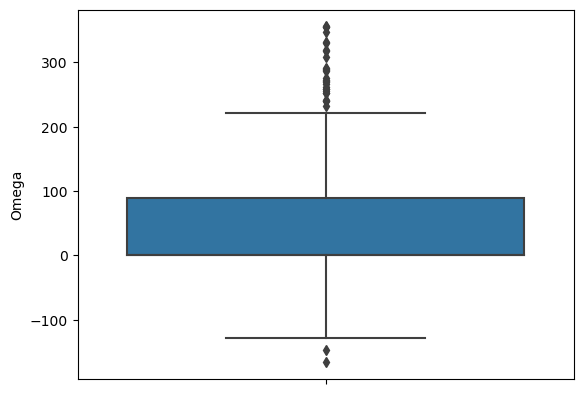

In [133]:
# Detect outliers:
Q1 = merged_df1['Omega'].quantile(0.25)
print('Q1: ',Q1)
Q3 = merged_df1['Omega'].quantile(0.75)
print('Q3: ',Q3)
IQR = Q3 - Q1
print('IQR: ',IQR)

lower_bound = Q1 -1.5 * IQR
print('lower_bound: ',lower_bound)
upper_bound = Q3 +1.5 * IQR
print('upper_bound: ',upper_bound)

# Handling Outliers
filter_lower_bound = (merged_df1['Omega'] < lower_bound)
filter_upper_bound = (merged_df1['Omega'] > upper_bound)
# Check outliers values:
print(merged_df1['Omega'][(filter_lower_bound | filter_upper_bound)])

# IQR 
Q1 = np.percentile(merged_df1['Omega'], 25, 
                method = 'midpoint') 
  
Q3 = np.percentile(merged_df1['Omega'], 75, 
                method = 'midpoint') 
IQR = Q3 - Q1 
  
print("Shape: ", merged_df1.shape) 
  
# Upper bound 
upper = np.where(merged_df1['Omega'] >= (Q3+1.5*IQR)) 
  
# Lower bound 
lower = np.where(merged_df1['Omega']<= (Q1-1.5*IQR)) 
print(upper, lower,lower[0],upper[0],IQR) 
  
sns.boxplot(data = merged_df1, y = 'Omega');
plt.show()

Original DataFrame Shape: (355, 32)
DataFrame Shape after Removing Outliers: (354, 32)


<Axes: ylabel='Inclination'>

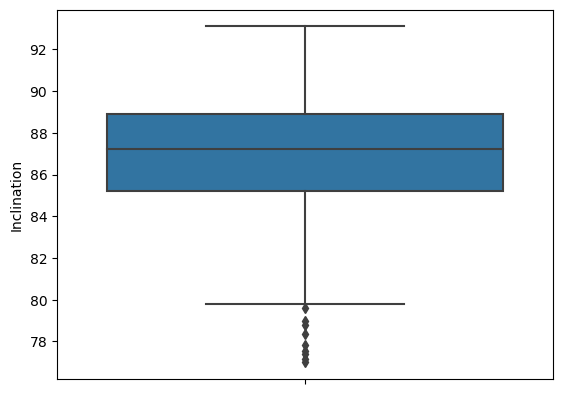

In [134]:
z = np.abs(stats.zscore(merged_df1['Inclination']))
threshold_z = 3

outlier_mask = z > threshold_z
no_outliers = merged_df1[~outlier_mask]
print("Original DataFrame Shape:", merged_df1.shape)
#sns.boxplot(data = merged_df1, y = 'Inclination')
print("DataFrame Shape after Removing Outliers:", no_outliers.shape)
sns.boxplot(data = no_outliers, y = 'Inclination')

Due to the domain logic, some properties should not be removed since the very high or low values are relative when it comes to other properties. So even though some values seem like outliers, it is relative and cannot be dropped. Therefore, dropping the "outliers" would actually only lead to loss of data.

## Question 1: Does the inclination of exoplanets play a role in determining the discovery techniques employed and the resulting eccentricity?

<Axes: xlabel='Inclination', ylabel='Eccentricity'>

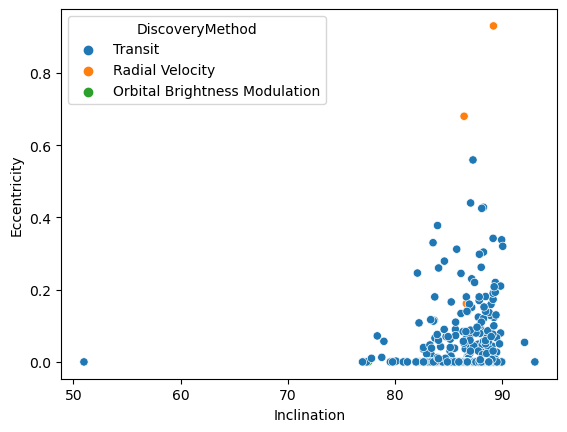

In [135]:
aggdf = merged_df1[["Inclination", "Eccentricity", "DiscoveryMethod"]]
sns.scatterplot(data = aggdf, x = "Inclination", y = "Eccentricity", hue = "DiscoveryMethod")

The scatterplot shows the relationship between inclination and eccentricity while protraying the discovery method of each exoplanet. It illustrates how the eccentricity is affected as the inclination increases whilst displaying the discovery methods of each exoplanet to pick up on patterns as well.

According to the plot, the relationship between inclination and eccentricity seems to show a cluster where most exoplanets that have high inclination seem to have low eccentricity. However, this relationship is not strictly applicable since some exoplanets tend to have high eccentricity as the inclination increases. Additionaly, it is evident that almost all exoplanets that have been discovered by transit have high inclination degrees ranging from 78° to 93°. 



# Retrieving data on exoplanet molecular composition from the web

In [136]:
# Since the web page we needed to scrape had an iframe, which an embedded HTML document within another HTML document, 
# we couldn't use the traditional requests.get method to retrieve data from the web, as the data returned was incomplete
# instead, we used a selenium web driver

In [137]:
#this extracts data from the chrome browser, so if chrome is not downloaded it won't work
from selenium import webdriver #import webdriver package from selenium library
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

# Create a new instance of the Chrome driver
service = Service(ChromeDriverManager().install()) #ensures the correct version of ChromeDriver is downloaded based on installed Chrome browser version
driver = webdriver.Chrome(service=service) #create new instance of chrome webdriver

# Navigate to the URL
url = "https://research.iac.es/proyecto/exoatmospheres/table.php"
driver.get(url)

# Switch to the iframe
iframe = driver.find_element(By.TAG_NAME, "iframe") #finding the iframe element
driver.switch_to.frame(iframe) # allow to interact with the content inside the iframe

# Get the page source of the iframe content
iframe_page_source = driver.page_source #retrieves the HTML source code of the iframe

# Print the iframe page source
print(iframe_page_source) #html data

# Switch back to the default content
driver.switch_to.default_content()

# Close the browser
driver.quit()

<html><head>
    <meta charset="utf-8">    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>IAC community database for exoplanet atmospheric observations</title>
    <meta name="description" content="This Exoplanet Atmospheres Database is built for the community and maintained by the community. This is an exciting and vibrant field of research, where new discoveries and publications occur at a very fast pace and it is easy to miss many interesting results. The main purpose of this database is to become a quick and useful repository of all available exoplanet atmospheres observations, and also to help in the gathering of useful references for a given planet or plane types.">
    <meta name="keywords" content="exoplanet, atmospheres, spectroscopy, iac">
    <meta name="author" content="IAC Exoplanets and Astrobiology Group - japp">
    <link href="https://fonts.googleapis.com/css?family=Roboto:300,400,700" rel="stylesheet">
    <link href="https://fonts.g

In [138]:
iframe_page_source


'<html><head>\n    <meta charset="utf-8">    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n    <title>IAC community database for exoplanet atmospheric observations</title>\n    <meta name="description" content="This Exoplanet Atmospheres Database is built for the community and maintained by the community. This is an exciting and vibrant field of research, where new discoveries and publications occur at a very fast pace and it is easy to miss many interesting results. The main purpose of this database is to become a quick and useful repository of all available exoplanet atmospheres observations, and also to help in the gathering of useful references for a given planet or plane types.">\n    <meta name="keywords" content="exoplanet, atmospheres, spectroscopy, iac">\n    <meta name="author" content="IAC Exoplanets and Astrobiology Group - japp">\n    <link href="https://fonts.googleapis.com/css?family=Roboto:300,400,700" rel="stylesheet">\n    <link href="https:/

## Parse the data

In [139]:
from bs4 import BeautifulSoup

In [140]:
soup= BeautifulSoup(iframe_page_source,"html.parser") #the parser identifies elements, attributes, and their relationships 

In [141]:
print(soup.prettify()) #view in a nice indented way

<html>
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
  <title>
   IAC community database for exoplanet atmospheric observations
  </title>
  <meta content="This Exoplanet Atmospheres Database is built for the community and maintained by the community. This is an exciting and vibrant field of research, where new discoveries and publications occur at a very fast pace and it is easy to miss many interesting results. The main purpose of this database is to become a quick and useful repository of all available exoplanet atmospheres observations, and also to help in the gathering of useful references for a given planet or plane types." name="description"/>
  <meta content="exoplanet, atmospheres, spectroscopy, iac" name="keywords"/>
  <meta content="IAC Exoplanets and Astrobiology Group - japp" name="author"/>
  <link href="https://fonts.googleapis.com/css?family=Roboto:300,400,700" rel="stylesheet"/>
  <link href="https://fonts.g

## Look for the needed elements

In [142]:
table = soup.find("table") #getting single element table

In [143]:
type(table)

bs4.element.Tag

In [144]:
table_headers=table.find_all('th') #getting all table headers in the table

In [145]:
# Extract the text from the table headers
headers_text = [header.text for header in table_headers]

# Print the headers without styling
print(headers_text)

['Exoplanet', 'Type', 'Period\xa0(d)', 'Radius\xa0(RJ⊕)', 'Mass\xa0(MJ⊕)', 'Teq\xa0(K)', 'Vmag', 'Jmag', 'Kmag', 'TSM', 'ESM', 'Albedo', 'Ph\xa0curve', 'Occultation', 'Molecules', '\xa0']


In [146]:
# Extract the text from the table headers and remove non-breaking spaces 
#(this is because the non-breaking spaces caused problems with correct data retrival from each according column)
headers_text = [header.text.replace('\xa0', '') for header in table_headers]

print(headers_text)

['Exoplanet', 'Type', 'Period(d)', 'Radius(RJ⊕)', 'Mass(MJ⊕)', 'Teq(K)', 'Vmag', 'Jmag', 'Kmag', 'TSM', 'ESM', 'Albedo', 'Phcurve', 'Occultation', 'Molecules', '']


## Extract table data (rows) 

In [147]:
#create empty lists for the desired columns
PlanetName=[]
PlanetType=[]
Molecules=[]
Molecules_Detection = []
#Molecules_No_Detection = []
#Molecules_Upper_Limit = []

In [148]:
rows = table.find_all('tr') #find table row elements

In [149]:
rows

[<tr class="bg-info tablesorter-headerRow" role="row">
 <th aria-disabled="false" aria-label="Exoplanet: Ascending sort applied, activate to apply a descending sort" aria-sort="ascending" class="filter-match tablesorter-header tablesorter-headerAsc" data-column="0" role="columnheader" scope="col" style="user-select: none;" tabindex="0" unselectable="on"><div class="tablesorter-header-inner">Exoplanet</div></th>
 <th aria-disabled="false" aria-label="Type: No sort applied, activate to apply an ascending sort" aria-sort="none" class="tablesorter-header tablesorter-headerUnSorted" data-column="1" role="columnheader" scope="col" style="user-select: none;" tabindex="0" unselectable="on"><div class="tablesorter-header-inner">Type</div></th>
 <th aria-disabled="false" aria-label="Period (d): No sort applied, activate to apply an ascending sort" aria-sort="none" class="tablesorter-header tablesorter-headerUnSorted" data-column="2" role="columnheader" scope="col" style="user-select: none;" tabi

In [150]:
#iterate through the rows and fill the lists with the column text values at the appropriate index
i = 0
for row in rows:
    if i == 0:  # skip the header
        i += 1
        continue
    cols = row.find_all('td')
    PlanetName.append(cols[0].a.get_text() if cols[0].a else cols[0].text) #we only get the text of the element <a> because otherwise it'll get all the text for the subsequent divs that appear when hovering
    PlanetType.append(cols[1].text)
    Molecules.append(cols[14].text)
    
    # Extract molecules with "Detection", "upper_limit_molecules" and "No Detection" labels
    # detection means that the molecule is proven and certain to be present
    #upper limit means that there have been no formal proof that the molecule exists but it certain that it at least exists above a certain amount
    #no detection means that the molecule has been proven to for sure not exist on the exoplanet
    molecules = cols[14].find_all('span', class_='label') #get the label of the span elements in the molecules field
    detected_molecules = [mol.get_text() for mol in molecules if 'label-success' in mol['class']] #use list comprehension to check the label
    #upper_limit_molecules = [mol.get_text() for mol in molecules if 'label-warning' in mol['class']]
    #no_detection_molecules = [mol.get_text() for mol in molecules if 'label-danger' in mol['class']]
    Molecules_Detection.append(', '.join(detected_molecules))
    #Molecules_No_Detection.append(', '.join(no_detection_molecules))
    #Molecules_Upper_Limit.append(','.join(upper_limit_molecules))

len(PlanetName), len(Molecules)

(234, 234)

In [151]:
Molecules_Detection

['',
 'CH4, CO, H2O',
 'H',
 'Molecular ratios: C/O, etc...',
 'CO, H2O',
 'H',
 '',
 '',
 'CO, H2O, Molecular ratios: C/O, etc...',
 'CO',
 'Featureless spectra, H2O, Rayleigh Scattering, VO',
 '',
 '',
 'Featureless spectra',
 'H',
 'Featureless spectra',
 'HCN',
 'Featureless spectra, He',
 'Featureless spectra',
 'H, He, Rayleigh Scattering',
 '',
 'H2O',
 'H2O, K, Na',
 '',
 '',
 '',
 '',
 'CO2, FeH, H2O',
 '',
 '',
 'C+, H, H2O, He, NH3',
 'H2O',
 '',
 'Featureless spectra',
 'CO2, Cloudy, Featureless spectra, H2O, He, Rayleigh Scattering',
 'Featureless spectra',
 'Featureless spectra',
 'Featureless spectra, H2O, He, TiO',
 '',
 'CO2, H, H2O, He, Rayleigh Scattering',
 '',
 'CrH, Featureless spectra, H2O, MgH, TiO',
 '',
 'MgH, Na',
 'Featureless spectra',
 'TiO',
 'Ca+, He, Na',
 'Ca+, Cr+, Cr, Fe+, Fe, H, Mg, Na, V',
 'H2O',
 'Cloudy',
 'CO2, H2O',
 '',
 'H',
 'He',
 '',
 'Ba+, Ca+, Ca, Cr, Fe+, Fe, H, Mg, Na, Rb, Sm, Ti+',
 '',
 '',
 'CH4, H2O',
 'H2O',
 'CO2, Fe, H2O, Molec

## Create a dataframe

In [152]:
# create a dataframe
import pandas as pd
exoMoleculesDF = pd.DataFrame({'PlanetName':PlanetName,'PlanetType':PlanetType,'Molecules':Molecules,'Molecules_Detection': Molecules_Detection})
exoMoleculesDF.head(50)

,PlanetName,PlanetType,Molecules,Molecules_Detection
0,,,,
1,2M0437 b,Hot Jupiter,\nCH4 CO H2O,"CH4, CO, H2O"
2,2M 0103-55 (AB) b,Jupiter,\nH,H
3,51 Eri b,Warm Jupiter,"\nMolecular ratios: C/O, etc...","Molecular ratios: C/O, etc..."
4,51 Peg b,Hot Jupiter,\nCO H2O,"CO, H2O"
5,55 Cnc b,Warm Jupiter,\nH,H
6,55 Cnc e,Hot Super-Earth,\nCa+ Ca Fe+ Fe H H HCN He He K Mg Na,
7,AU Mic b,Warm Neptune,\nH H He,
8,beta Pic b,Jupiter,"\nCO H2O Molecular ratios: C/O, etc...","CO, H2O, Molecular ratios: C/O, etc..."
9,CI Tau b,Jupiter,\nCO,CO


In [153]:
for col in exoMoleculesDF.columns:
    exoMoleculesDF[col] = exoMoleculesDF[col].str.replace(r'[\n\b]', '', regex=True) #remove all the '\n' and '\b' values

In [154]:
exoMoleculesDF.head()

,PlanetName,PlanetType,Molecules,Molecules_Detection
0,,,,
1,2M0437 b,Hot Jupiter,CH4 CO H2O,"CH4, CO, H2O"
2,2M 0103-55 (AB) b,Jupiter,H,H
3,51 Eri b,Warm Jupiter,"Molecular ratios: C/O, etc...","Molecular ratios: C/O, etc..."
4,51 Peg b,Hot Jupiter,CO H2O,"CO, H2O"


In [155]:
exoMoleculesDF.tail()

,PlanetName,PlanetType,Molecules,Molecules_Detection
229,WD 1856+534 b,Cold Jupiter,Featureless spectra,Featureless spectra
230,XO-1 b,Hot Jupiter,H2O,H2O
231,XO-2N b,Hot Jupiter,H2O K Na,"K, Na"
232,XO-3 b,Hot Jupiter,,
233,XO-4 b,Hot Jupiter,,


# Cleaning the scraped data

## feature engineering: looking for desired and toxic molecules

In [156]:
#create column for each molecule for habitable planets by searching for it's presence in the detected molcules col 
import re

#look for molecule
def has_element(molecules, patterns):
    for molecule in molecules:
            if patterns.search(molecule):
                return 1
    return 0
 ##desired molecules for habitability##
    
# Define the patterns for each molecule
patterns = re.compile(r'\bH2O\b')
# Apply the function to the DataFrame
exoMoleculesDF['H2O'] = exoMoleculesDF['Molecules_Detection'].apply(lambda x: has_element(x.split(), patterns))

patterns = re.compile(r'\bCH4\b')
exoMoleculesDF['CH4'] = exoMoleculesDF['Molecules_Detection'].apply(lambda x: has_element(x.split(), patterns))

patterns = re.compile(r'\bCO2\b')
exoMoleculesDF['CO2'] = exoMoleculesDF['Molecules_Detection'].apply(lambda x: has_element(x.split(), patterns))


patterns = re.compile(r'\bNH3\b')
exoMoleculesDF['NH3'] = exoMoleculesDF['Molecules_Detection'].apply(lambda x: has_element(x.split(), patterns))

     ##toxic molecules##
patterns = re.compile(r'\bCO\b')
exoMoleculesDF['CO'] = exoMoleculesDF['Molecules_Detection'].apply(lambda x: has_element(x.split(), patterns))

patterns = re.compile(r'\bSO2\b')
exoMoleculesDF['SO2'] = exoMoleculesDF['Molecules_Detection'].apply(lambda x: has_element(x.split(), patterns))

patterns = re.compile(r'\bHCN\b')
exoMoleculesDF['HCN'] = exoMoleculesDF['Molecules_Detection'].apply(lambda x: has_element(x.split(), patterns))

exoMoleculesDF.head()


,PlanetName,PlanetType,Molecules,Molecules_Detection,H2O,CH4,CO2,NH3,CO,SO2,HCN
0,,,,,0,0,0,0,0,0,0
1,2M0437 b,Hot Jupiter,CH4 CO H2O,"CH4, CO, H2O",1,1,0,0,1,0,0
2,2M 0103-55 (AB) b,Jupiter,H,H,0,0,0,0,0,0,0
3,51 Eri b,Warm Jupiter,"Molecular ratios: C/O, etc...","Molecular ratios: C/O, etc...",0,0,0,0,0,0,0
4,51 Peg b,Hot Jupiter,CO H2O,"CO, H2O",1,0,0,0,1,0,0


## remove the first empty row

In [157]:
# removing that first empty row
import pandas as pd

exoMoleculesDF.drop(exoMoleculesDF.index[0], inplace=True) #modify the dataframe itself

exoMoleculesDF #show

,PlanetName,PlanetType,Molecules,Molecules_Detection,H2O,CH4,CO2,NH3,CO,SO2,HCN
1,2M0437 b,Hot Jupiter,CH4 CO H2O,"CH4, CO, H2O",1,1,0,0,1,0,0
2,2M 0103-55 (AB) b,Jupiter,H,H,0,0,0,0,0,0,0
3,51 Eri b,Warm Jupiter,"Molecular ratios: C/O, etc...","Molecular ratios: C/O, etc...",0,0,0,0,0,0,0
4,51 Peg b,Hot Jupiter,CO H2O,"CO, H2O",1,0,0,0,1,0,0
5,55 Cnc b,Warm Jupiter,H,H,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
229,WD 1856+534 b,Cold Jupiter,Featureless spectra,Featureless spectra,0,0,0,0,0,0,0
230,XO-1 b,Hot Jupiter,H2O,H2O,1,0,0,0,0,0,0
231,XO-2N b,Hot Jupiter,H2O K Na,"K, Na",0,0,0,0,0,0,0
232,XO-3 b,Hot Jupiter,,,0,0,0,0,0,0,0


## Handling missing values

In [158]:
exoMoleculesDF.isnull().sum() #for some reason, it shows that no values for the molecules are null, even tho thats not true
#this means that the empty values may be represented by ''

PlanetName             0
PlanetType             0
Molecules              0
Molecules_Detection    0
H2O                    0
CH4                    0
CO2                    0
NH3                    0
CO                     0
SO2                    0
HCN                    0
dtype: int64

In [159]:
#check the dataframe datatypes
exoMoleculesDF.dtypes

PlanetName             object
PlanetType             object
Molecules              object
Molecules_Detection    object
H2O                     int64
CH4                     int64
CO2                     int64
NH3                     int64
CO                      int64
SO2                     int64
HCN                     int64
dtype: object

In [160]:
#the data type of molecules is object so they are treated as strings

In [161]:
# Check for empty strings
empty_strings = exoMoleculesDF == ''
print(empty_strings.sum())

PlanetName              0
PlanetType              0
Molecules              33
Molecules_Detection    81
H2O                     0
CH4                     0
CO2                     0
NH3                     0
CO                      0
SO2                     0
HCN                     0
dtype: int64


In [162]:
#Replace empty strings with NaN to treat empty strings as missing values
exoMoleculesDF = exoMoleculesDF.replace(r'^\s*$', pd.NA, regex=True)

<Axes: >

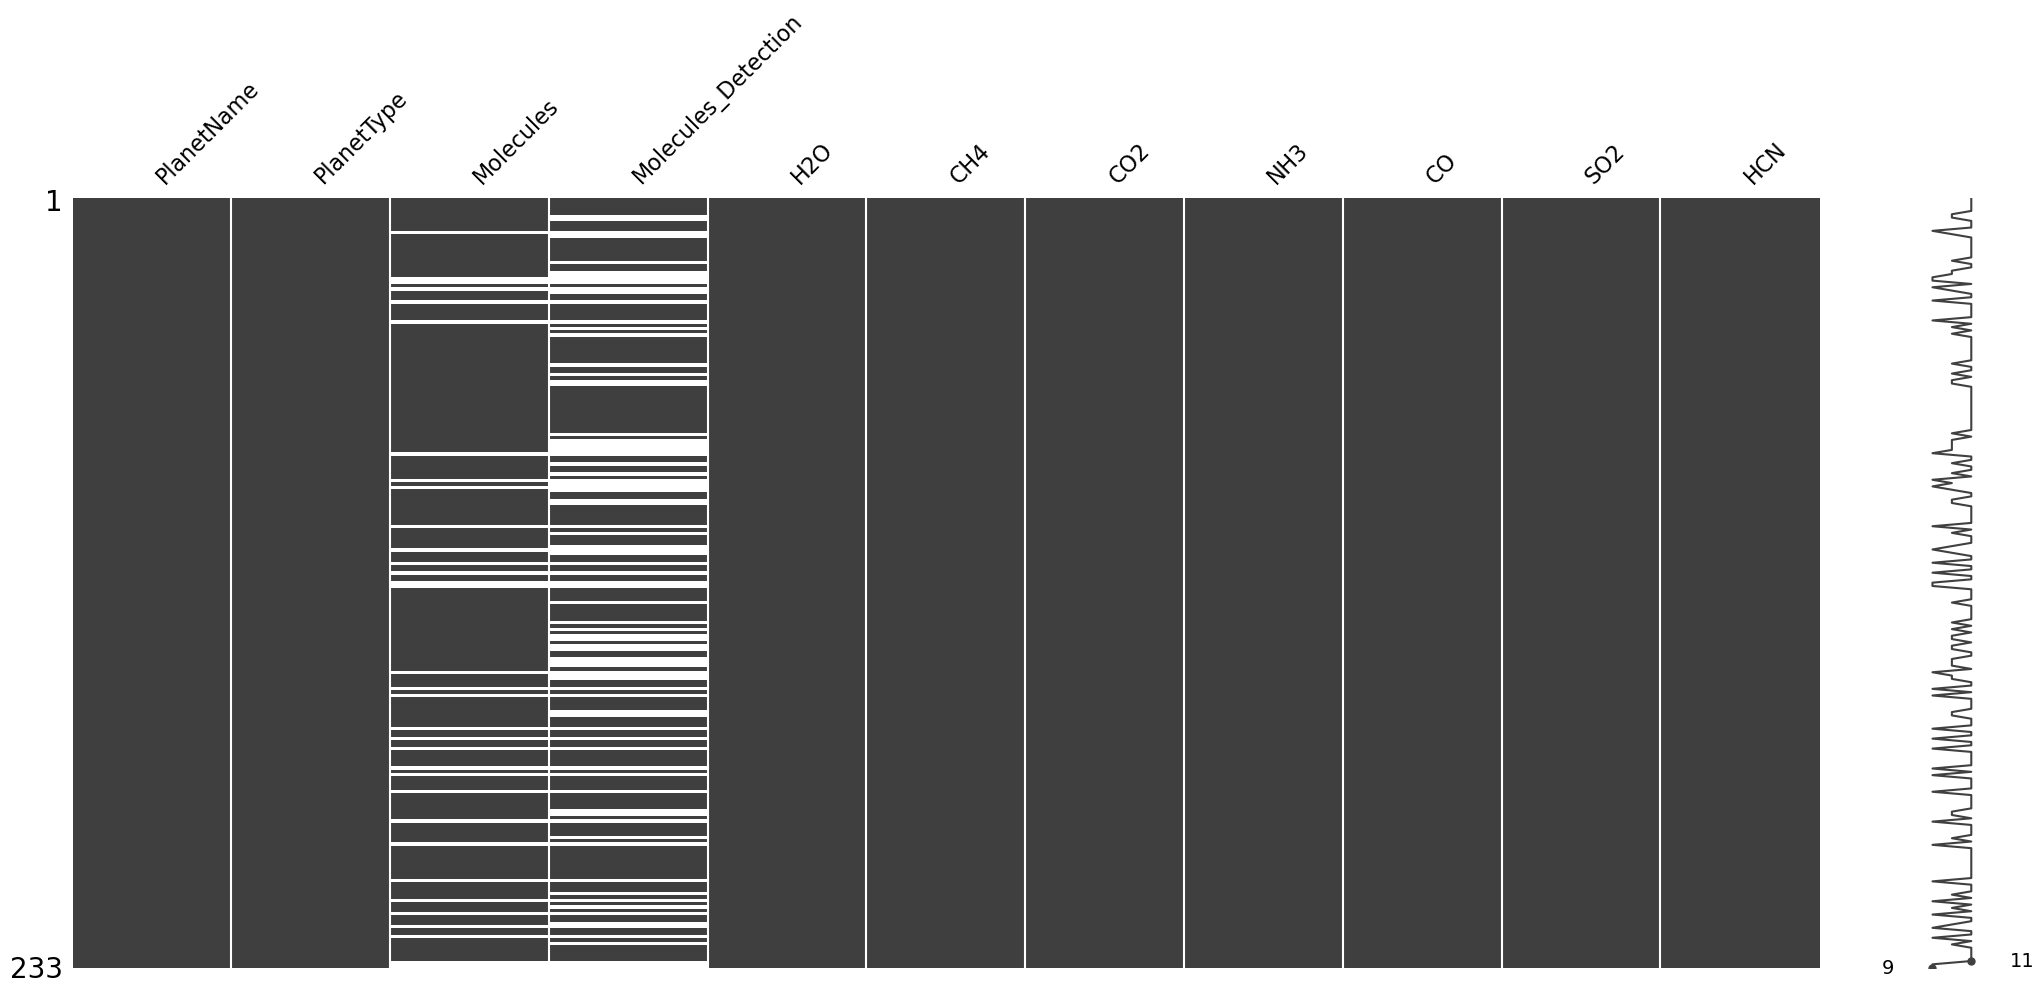

In [163]:
import missingno as msno 
msno.matrix(exoMoleculesDF) 

In [164]:
#Drop rows with empty values
exoMoleculesDF = exoMoleculesDF.dropna(subset=['Molecules'],how='any')
#drop also detected molecules?

<Axes: >

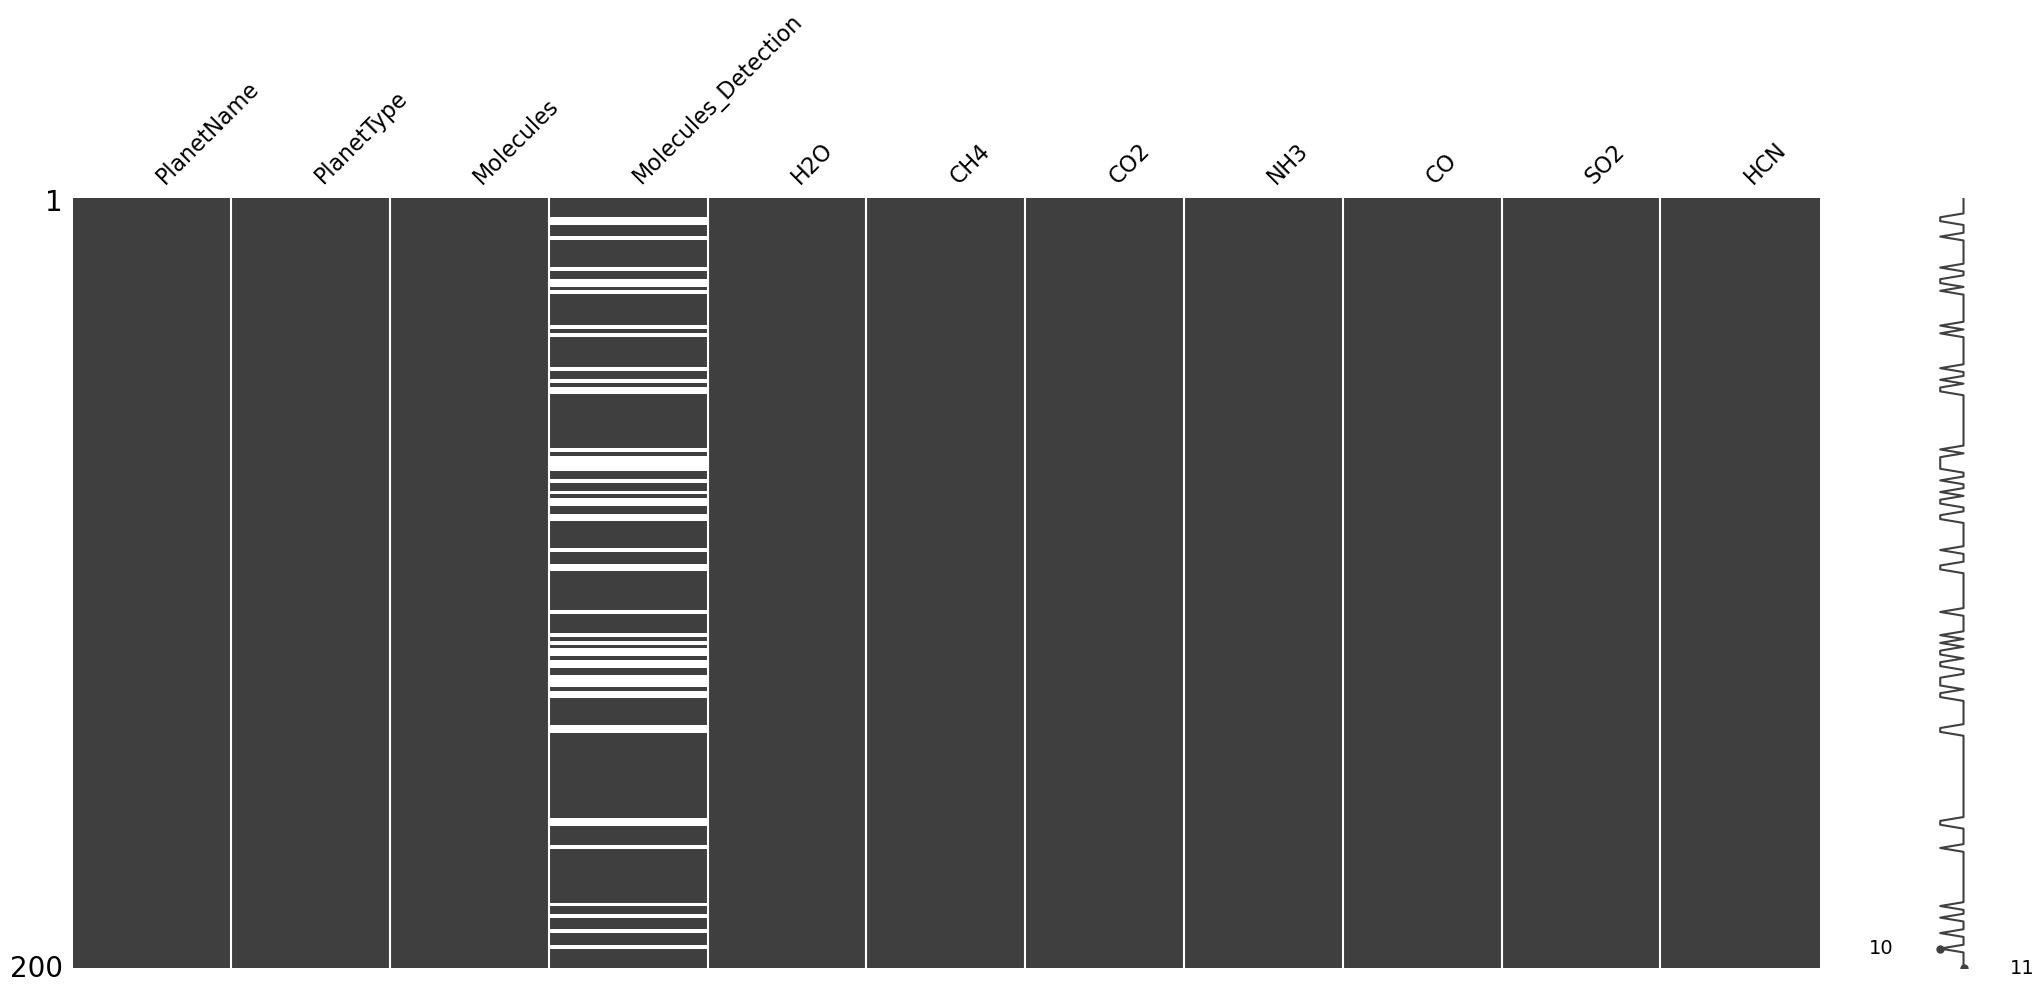

In [165]:
msno.matrix(exoMoleculesDF) 

## Imputing the null detected molecules

In [166]:
exoMoleculesDF['Molecules_Detection']=exoMoleculesDF['Molecules_Detection'].fillna('No Detection')

In [167]:
exoMoleculesDF.head()

,PlanetName,PlanetType,Molecules,Molecules_Detection,H2O,CH4,CO2,NH3,CO,SO2,HCN
1,2M0437 b,Hot Jupiter,CH4 CO H2O,"CH4, CO, H2O",1,1,0,0,1,0,0
2,2M 0103-55 (AB) b,Jupiter,H,H,0,0,0,0,0,0,0
3,51 Eri b,Warm Jupiter,"Molecular ratios: C/O, etc...","Molecular ratios: C/O, etc...",0,0,0,0,0,0,0
4,51 Peg b,Hot Jupiter,CO H2O,"CO, H2O",1,0,0,0,1,0,0
5,55 Cnc b,Warm Jupiter,H,H,0,0,0,0,0,0,0


<Axes: >

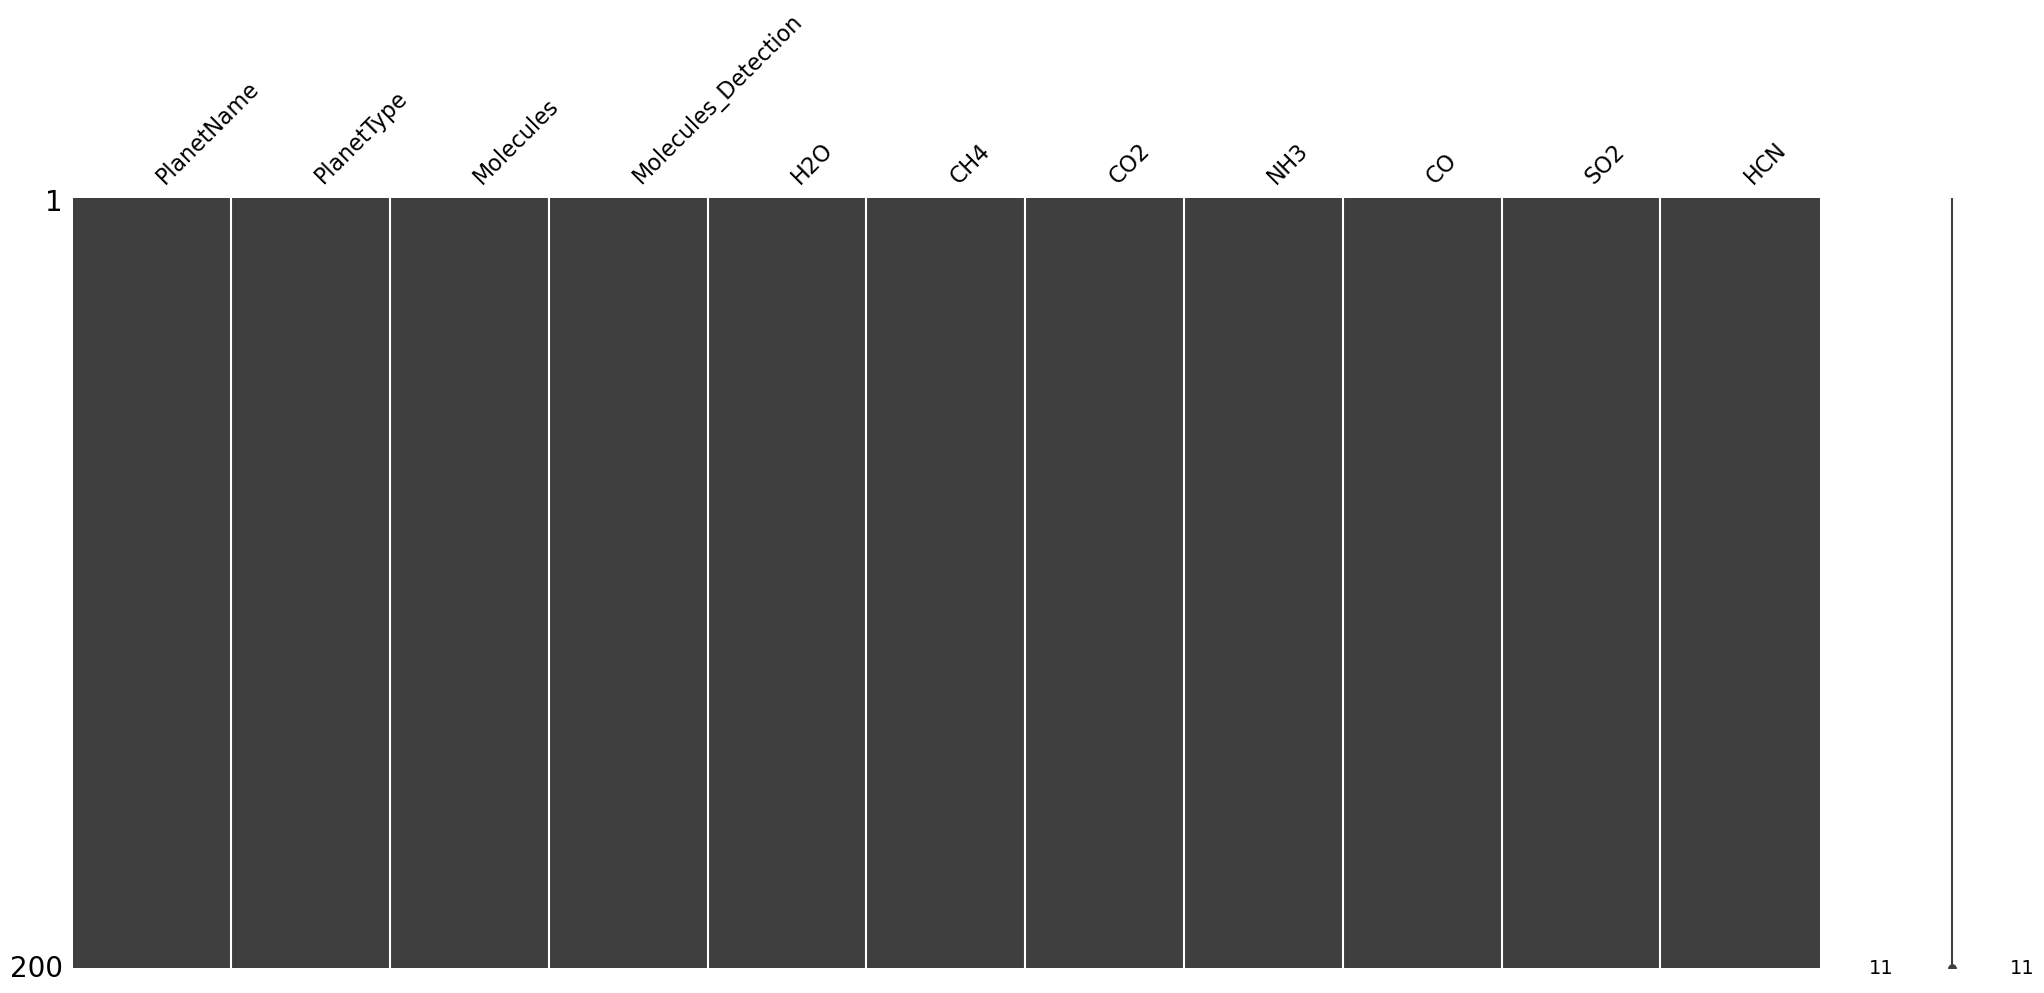

In [168]:
msno.matrix(exoMoleculesDF) 

# Integrating Datasets

Some records were dropped in the previous cleaning phase, however they included null values in the molecules column and would have provided no additional infromation of value, so no real data loss occurred. Since the scraped dataset records were reduced, some data was lost during merging as not all planets from the original dataset were also included in the scraped data.

In [169]:
exoplanets = pd.read_csv("ExoplanetsClean.csv")
exoplanets.head()

,PlanetName,HostName,NumOfStars,NumOfPlanets,DiscoveryMethod,DiscoveryYear,DiscoveryFacility,ControversialFlag,OrbitalPeriod,OrbitSemi-MajorAxis,...,Declination,DistancetoPlanetarySystem,StellarBrightnessGaia,PlanetMass,StellarMass,PlanetRadiusKm,StellarRadiusKm,PlanetGravity,StellarVolume,StellarDensity
0,55 Cnc e,55 Cnc,2,5,Radial Velocity,2004,McDonald Observatory,0,0.736547,0.01544,...,28.329815,12.5855,5.72973,4.771948e+25,1.809535e+30,11945.625,653958.0,2.231946e+07,1.171489e+18,1.544645e+12
1,55 Cnc e,55 Cnc,2,5,Radial Velocity,2004,McDonald Observatory,0,0.736546,0.01583,...,28.329815,12.5855,5.72973,4.998899e+25,1.789650e+30,13844.183,667872.0,1.740786e+07,1.247867e+18,1.434167e+12
2,55 Cnc e,55 Cnc,2,5,Radial Velocity,2004,McDonald Observatory,0,0.736544,0.01544,...,28.329815,12.5855,5.72973,4.664444e+25,1.809535e+30,13251.680,653958.0,1.772816e+07,1.171489e+18,1.544645e+12
3,AU Mic b,AU Mic,1,3,Transit,2020,Transiting Exoplanet Survey Satellite (TESS),0,8.463080,0.06490,...,-31.342450,9.7221,7.84038,1.012508e+30,1.014135e+30,25210.047,514818.0,1.063303e+11,5.715441e+17,1.774377e+12
4,AU Mic c,AU Mic,1,3,Transit,2021,Transiting Exoplanet Survey Satellite (TESS),0,18.859690,0.11080,...,-31.342450,9.7221,7.84038,1.014545e+30,1.014135e+30,16067.662,514818.0,2.622840e+11,5.715441e+17,1.774377e+12


In [170]:
#merge all the common planet names between the two data sets
merged_df = pd.merge(exoMoleculesDF, exoplanets, on="PlanetName", how="inner")
merged_df.head()

,PlanetName,PlanetType,Molecules,Molecules_Detection,H2O,CH4,CO2,NH3,CO,SO2,...,Declination,DistancetoPlanetarySystem,StellarBrightnessGaia,PlanetMass,StellarMass,PlanetRadiusKm,StellarRadiusKm,PlanetGravity,StellarVolume,StellarDensity
0,55 Cnc e,Hot Super-Earth,Ca+ Ca Fe+ Fe H H HCN He He K Mg Na,No Detection,0,0,0,0,0,0,...,28.329815,12.5855,5.72973,4.771948e+25,1.809535e+30,11945.625,653958.0,2.231946e+07,1.171489e+18,1.544645e+12
1,55 Cnc e,Hot Super-Earth,Ca+ Ca Fe+ Fe H H HCN He He K Mg Na,No Detection,0,0,0,0,0,0,...,28.329815,12.5855,5.72973,4.998899e+25,1.789650e+30,13844.183,667872.0,1.740786e+07,1.247867e+18,1.434167e+12
2,55 Cnc e,Hot Super-Earth,Ca+ Ca Fe+ Fe H H HCN He He K Mg Na,No Detection,0,0,0,0,0,0,...,28.329815,12.5855,5.72973,4.664444e+25,1.809535e+30,13251.680,653958.0,1.772816e+07,1.171489e+18,1.544645e+12
3,AU Mic b,Warm Neptune,H H He,No Detection,0,0,0,0,0,0,...,-31.342450,9.7221,7.84038,1.012508e+30,1.014135e+30,25210.047,514818.0,1.063303e+11,5.715441e+17,1.774377e+12
4,CoRoT-1 b,Hot Jupiter,Featureless spectra H H2O Rayleigh Scattering VO,"Featureless spectra, H2O, Rayleigh Scattering, VO",1,0,0,0,0,0,...,-3.102139,787.9090,13.45700,1.955065e+27,1.889075e+30,106395.700,772227.0,1.152707e+07,1.928961e+18,9.793223e+11


In [171]:
merged_df.shape

(236, 36)

## Handling redundancies

In [172]:
# Remove duplicate rows based on repeated planet name
cleanedDF = merged_df.drop_duplicates(subset=["PlanetName"])
cleanedDF.head()

,PlanetName,PlanetType,Molecules,Molecules_Detection,H2O,CH4,CO2,NH3,CO,SO2,...,Declination,DistancetoPlanetarySystem,StellarBrightnessGaia,PlanetMass,StellarMass,PlanetRadiusKm,StellarRadiusKm,PlanetGravity,StellarVolume,StellarDensity
0,55 Cnc e,Hot Super-Earth,Ca+ Ca Fe+ Fe H H HCN He He K Mg Na,No Detection,0,0,0,0,0,0,...,28.329815,12.58550,5.72973,4.771948e+25,1.809535e+30,11945.625,653958.0,2.231946e+07,1.171489e+18,1.544645e+12
3,AU Mic b,Warm Neptune,H H He,No Detection,0,0,0,0,0,0,...,-31.342450,9.72210,7.84038,1.012508e+30,1.014135e+30,25210.047,514818.0,1.063303e+11,5.715441e+17,1.774377e+12
4,CoRoT-1 b,Hot Jupiter,Featureless spectra H H2O Rayleigh Scattering VO,"Featureless spectra, H2O, Rayleigh Scattering, VO",1,0,0,0,0,0,...,-3.102139,787.90900,13.45700,1.955065e+27,1.889075e+30,106395.700,772227.0,1.152707e+07,1.928961e+18,9.793223e+11
5,GJ 436 b,Warm Neptune,FeH H H He,H,0,0,0,0,0,0,...,26.703067,9.75321,9.57148,1.516990e+26,1.113560e+30,26121.100,320022.0,1.483903e+07,1.372866e+17,8.111207e+12
6,GJ 1214 b,Warm Sub-Neptune,Featureless spectra He He He,"Featureless spectra, He",0,0,0,0,0,0,...,4.960680,14.64270,13.00890,5.022788e+25,3.579300e+29,17411.943,153054.0,1.105748e+07,1.501837e+16,2.383282e+13


## Removing space before Planet Type

In [173]:
cleanedDF['PlanetType'].unique()

array(['Hot Super-Earth', 'Warm Neptune', 'Hot Jupiter',
       'Warm Sub-Neptune', 'Warm Super-Earth', 'UltraHot Jupiter',
       'Hot Neptune', 'Hot Sub-Neptune', 'Temperate Neptune',
       ' Sub-Neptune', 'Temperate Jupiter', 'Temperate Super-Earth',
       'Warm Earth-size', 'Cold Super-Earth', 'Temperate Sub-Neptune',
       'UltraHot Neptune', ' Neptune', 'Warm Jupiter'], dtype=object)

In [174]:
cleanedDF['PlanetType']=cleanedDF['PlanetType'].str.lstrip(' ')

C:\Users\USER\AppData\Local\Temp\ipykernel_11476\542090594.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [175]:
cleanedDF['PlanetType'].unique()

array(['Hot Super-Earth', 'Warm Neptune', 'Hot Jupiter',
       'Warm Sub-Neptune', 'Warm Super-Earth', 'UltraHot Jupiter',
       'Hot Neptune', 'Hot Sub-Neptune', 'Temperate Neptune',
       'Sub-Neptune', 'Temperate Jupiter', 'Temperate Super-Earth',
       'Warm Earth-size', 'Cold Super-Earth', 'Temperate Sub-Neptune',
       'UltraHot Neptune', 'Neptune', 'Warm Jupiter'], dtype=object)

# New Questions

## Question 2: What molecules are most prevelant in which regions of the universe (3d graph)

In [176]:
import numpy as np
import plotly.graph_objects as go #to create interactive visualization



# Defining the molecules and their colors
molecules = ['H2O', 'CH4', 'CO2', 'NH3', 'CO', 'SO2', 'HCN']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']


for i, molecule in enumerate(molecules): #iterate over molecules list
    molecule_data = cleanedDF.where(cleanedDF[molecule]==1) #get the rows where the molecule is present, merged_df[molecule] is a boolean Series
    # Converting RA and DEC to Cartesian coordinates
    #.radians to convert from degrees to radians
    # coordinates expressed in AU (astronomical units)
    # One AU is defined as the mean distance between the Earth and the Sun
    # implicitly assuming that the Sun (or the center of the planetary system) is at the origin (0, 0, 0) of our coordinate system.
    molecule_x = molecule_data['DistancetoPlanetarySystem'] * np.cos(np.radians(molecule_data['RightAscension'])) * np.cos(np.radians(molecule_data['Declination']))
    molecule_y = molecule_data['DistancetoPlanetarySystem'] * np.sin(np.radians(molecule_data['RightAscension'])) * np.cos(np.radians(molecule_data['Declination']))
    molecule_z = molecule_data['DistancetoPlanetarySystem'] * np.sin(np.radians(molecule_data['Declination']))

    fig = go.Figure(data=[
       go.Scatter3d( #create the 3D scatter plot
        x=molecule_x,
        y=molecule_y,
        z=molecule_z,
        mode='markers',
        marker=dict(
            size=5,
            color=colors[i],
            opacity=0.8
        ),
        name=molecule, #legend label
        text=molecule_data['PlanetName'], #planet name displayed when hover
        hoverinfo='text'
     ),
     go.Scatter3d(  # Add a point for the Sun
     x=[0],  # the Sun is at the origin (0, 0, 0)
     y=[0],
     z=[0],
     mode='markers',
     marker=dict(
        size=10,
        color='yellow',
        opacity=1
     ),
     name='Sun', 
     text=['Sun'], 
     hoverinfo='text'
   )
  ])

    layout = go.Layout( #customize appearance of plot
        title=f'Distribution of {molecule} in the Universe',
        scene=dict(
            xaxis=dict(title='X (AU)'),
            yaxis=dict(title='Y (AU)'),
            zaxis=dict(title='Z (AU)')
        )
    )

    fig.update_layout(layout)
    fig.show()

**Description of the plot**

This plot was intened to visualize all the positions of planets in the universe that carry a certain molecule in their composition. This is becuase we wanted to derive insights of what regions or clusters in the universe hold desirable and undesirable molecules.

This plot holds multiple interactive 3d graphs that each show the distribution of a certain molecule in the universe. The x,y, and z axises are distance coordinates measures in AU. There is also a referance point which is the sun that lies in the origin of the graph.

This plot shows valuable insights as to the attainability (close to the sun in our solar system), distribution and availability of certain molecules in our universe. 

**Firstly, we have our desired molecules that are necessary for the habitability of a planet. They are: 'H2O', 'CH4', 'CO2', 'NH3'.**
H2O: Out of all the molecules, water seems to be the most common and abundant, as the graph shows many planets with H2O. These planets are also clustered closely to the sun, which means they are close to our solar system, with a few exceptions being further away. 
CH4: Methane seems to be much less abundant, with only 6 instances of planets containing the molecule. With a smaller scale, the planets seem to be also close to the sun with no prominant clustering.
CO2: There is a good amount of planets with carbon dioxide, and they are evenly distributed from the sun.
NH3: The number of planets with ammonia are sparse, only being 4.They are close to the sun and evenly distributed.

**Toxic molecules: 'CO', 'SO2', 'HCN'**
CO: There is quite a few planets with carbon monoxide, with no detectable clusters.
SO2: By far the least common molecule, only being on 2 planets. With one being very close to our sun.
HCN: Only 5 instances of hydrogen cyanide, randomly distributed.

## Question 3: Does planet type determine the atmospheric composition of exoplanets? 

In [177]:
grouped = cleanedDF.groupby('PlanetType').agg({'H2O': 'sum', 'CH4': 'sum','CO2': 'sum', 
                                        'NH3': 'sum', 'CO': 'sum', 'SO2': 'sum', 'HCN': 'sum', 
                                        'EquilibriumTemperature': 'mean', 'PlanetMass': 'mean', 'StellarMetallicity': 'mean'})
grouped.head(20)

,H2O,CH4,CO2,NH3,CO,SO2,HCN,EquilibriumTemperature,PlanetMass,StellarMetallicity
PlanetType,,,,,,,,,,
Cold Super-Earth,1,0,0,0,0,0,0,226.000000,3.344544e+25,-0.150000
Hot Jupiter,26,5,9,3,5,1,3,1267.545106,2.284326e+28,0.024583
Hot Neptune,2,0,0,0,0,0,0,1141.688952,1.902095e+88,0.137875
Hot Sub-Neptune,0,0,0,0,0,0,0,893.968041,6.371281e+29,-0.050000
Hot Super-Earth,0,0,0,0,0,0,0,858.573524,2.928467e+25,-0.019000
Neptune,0,0,0,0,0,0,0,943.742762,1.293425e+89,0.070000
Sub-Neptune,0,0,0,0,0,0,0,760.305986,3.606595e+27,0.290000
Temperate Jupiter,0,0,0,0,0,0,0,367.000000,2.102394e+30,-0.080000
Temperate Neptune,0,0,0,0,0,0,0,494.000000,1.463238e+26,0.150000


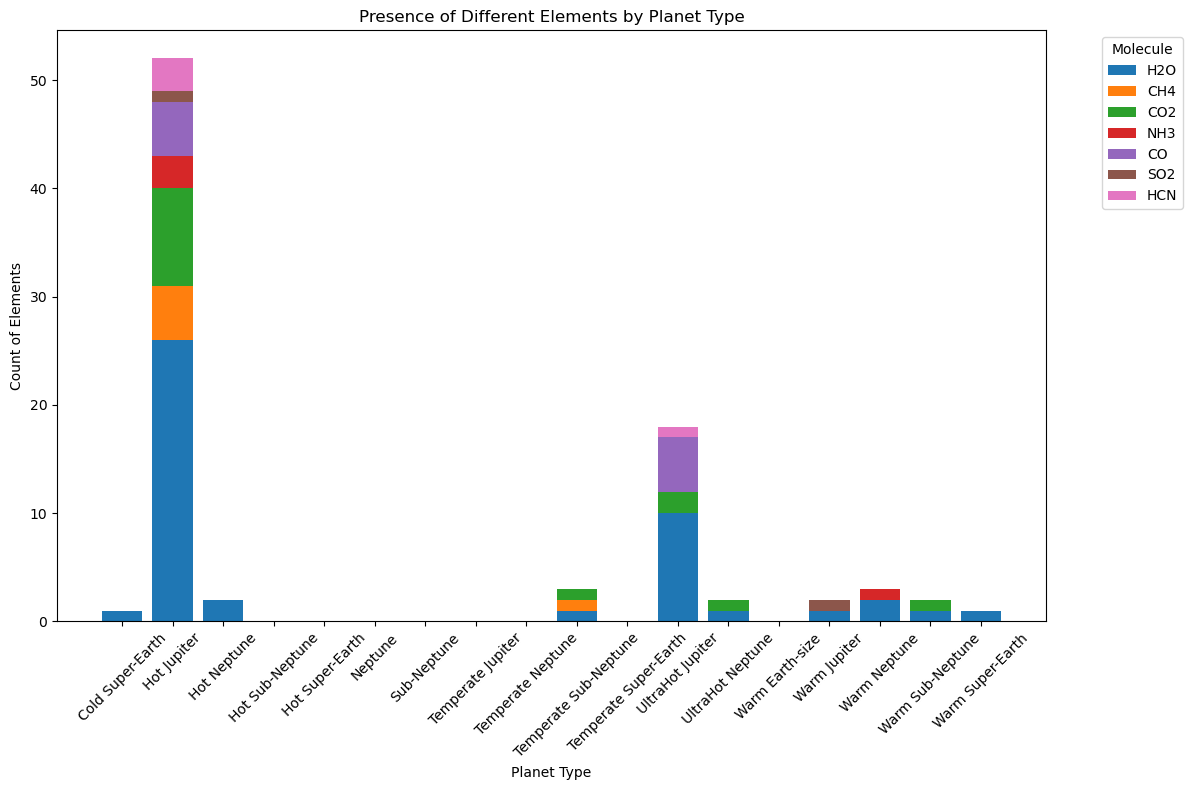

In [178]:
# Extract planet types and element counts
planet_types = grouped.index
molecules = grouped.columns[:-3]  # do not include last 3 non-molecule columns
counts = grouped[molecules].values

# Plotting the stacked bar plot
plt.figure(figsize=(12, 8))
bottom = np.zeros(len(planet_types))  # Initialize the bottom parameter for the first bar
for i, molecule in enumerate(molecules):
    plt.bar(planet_types, counts[:, i], label=molecule, bottom=bottom)
    bottom += counts[:, i]

plt.xlabel('Planet Type')
plt.ylabel('Count of Elements')
plt.title('Presence of Different Elements by Planet Type')
plt.legend(title='Molecule', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45) # angle the labels on x-axis for more readability
plt.tight_layout()
plt.show()

This graph shows the overall presence of different molecules based on planet types. 

Based on this, we can conclude that a great variety of molecules was detected on planets of type Hot Jupiter, with the confirmed presence of H2O, CH4, CO2, NH3, CO, SO2, and HCN molecules. It was followed by Temperate Super-Earth with the presence of H2O, CO2, CO, HCN with different ratios. With all the other planet types where molecules were detected, water was present but not as frequently as Hot Jupiter and Temperate Super-Earth. Some planet types also detected molecules such as CO2, NH3, SO2, and CH4, but they were very infrequent. 

Planets of type Neptune, Sub-Neptune, Hot Sub-Neptune, Temperate Jupiter, Temperate Sub-Neptune, and Warm-Earth size had no molecule detection, however this is probably due to the lack of records in the dataset of these types so no real conclusion can be drawn from these findings regarding these types.

## Question 4: Does the presence of certain molecules in an exoplanet's atmosphere correlate with the presence of other molecules?

In [179]:
subsetDF = cleanedDF[['H2O', 'CH4', 'CO2','NH3','CO','SO2','HCN']]
subsetDF.head()


,H2O,CH4,CO2,NH3,CO,SO2,HCN
0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0


<Axes: >

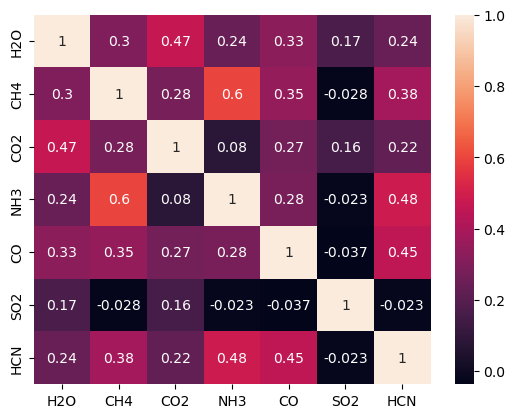

In [180]:
sns.heatmap(subsetDF.corr(), annot = True)

The above heatmap shows the correlation between different molecules in exoplanets' atmospheres. 

Sulfer Dioxide (SO2) seems to have a mild negative correlation with all other toxic molecules such as HCN, CO, NH3, and CH4 and a positive correlation with carbon dioxide and water, which are non toxic molecules. All other molecules are positively correlated to each other indicating that the presence of one element would most likely suggest that the other molecules are present as well. Since they have a considerably high correlation, Ammonia (NH3) and methane (CH4) are very likely to be present together in an exoplanet's atmosphere. In addition, Carbon Dioxide (CO2) and Water (H2O), are also moderately positively correlated. 

According to the results, the correlations between most molecules are not strong enough to indicate a relationship between their presence with correlation values ranging from 0.17 to 0.48. However, some molecules displayed stronger correlations than others, For instance Ammonia (NH3) and methane (CH4) having a correlation of 0.6 which prompts us to believe that there is a relatively strong relationship between them, and their presence are highly related. 

## Question 5: Does the temperature of the exoplanet influence its molecular composition?

In [181]:
def addTemp(row):
    if row["PlanetType"] == 'UltraHot Jupiter' or row["PlanetType"] == 'UltraHot Super-Earth' or row["PlanetType"] == 'UltraHot Neptune':
        return 'Uninhabitably Hot'
    elif row["PlanetType"] == 'Hot Super-Earth' or row["PlanetType"] == 'Hot Jupiter' or row["PlanetType"] == 'Hot Neptune' or row["PlanetType"] == 'Hot Sub-Neptune':
        return 'Dangerously Hot'
    elif row["PlanetType"] == 'Warm Super-Earth' or row["PlanetType"] == 'Warm Jupiter' or row["PlanetType"] == 'Warm Neptune' or row["PlanetType"] == 'Warm Sub-Neptune' or row["PlanetType"] == 'Warm Earth-size':
        return 'Mildly Hot'
    elif row["PlanetType"] == 'Temperate Neptune' or row["PlanetType"] == 'Temperate Jupiter' or row["PlanetType"] == 'Temperate Super-Earth' or row["PlanetType"] == 'Temperate Sub-Neptune':
        return 'Earth-like'
    elif row["PlanetType"] == 'Cold Super-Earth':
        return 'Mildly Cold'
    else:
        return 'Dangerously Cold'

# Apply the process_row function to each row
cleanedDF["TemperatureClass"] = cleanedDF.apply(addTemp, axis=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_11476\67370507.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [182]:
cleanedDF.head()

,PlanetName,PlanetType,Molecules,Molecules_Detection,H2O,CH4,CO2,NH3,CO,SO2,...,DistancetoPlanetarySystem,StellarBrightnessGaia,PlanetMass,StellarMass,PlanetRadiusKm,StellarRadiusKm,PlanetGravity,StellarVolume,StellarDensity,TemperatureClass
0,55 Cnc e,Hot Super-Earth,Ca+ Ca Fe+ Fe H H HCN He He K Mg Na,No Detection,0,0,0,0,0,0,...,12.58550,5.72973,4.771948e+25,1.809535e+30,11945.625,653958.0,2.231946e+07,1.171489e+18,1.544645e+12,Dangerously Hot
3,AU Mic b,Warm Neptune,H H He,No Detection,0,0,0,0,0,0,...,9.72210,7.84038,1.012508e+30,1.014135e+30,25210.047,514818.0,1.063303e+11,5.715441e+17,1.774377e+12,Mildly Hot
4,CoRoT-1 b,Hot Jupiter,Featureless spectra H H2O Rayleigh Scattering VO,"Featureless spectra, H2O, Rayleigh Scattering, VO",1,0,0,0,0,0,...,787.90900,13.45700,1.955065e+27,1.889075e+30,106395.700,772227.0,1.152707e+07,1.928961e+18,9.793223e+11,Dangerously Hot
5,GJ 436 b,Warm Neptune,FeH H H He,H,0,0,0,0,0,0,...,9.75321,9.57148,1.516990e+26,1.113560e+30,26121.100,320022.0,1.483903e+07,1.372866e+17,8.111207e+12,Mildly Hot
6,GJ 1214 b,Warm Sub-Neptune,Featureless spectra He He He,"Featureless spectra, He",0,0,0,0,0,0,...,14.64270,13.00890,5.022788e+25,3.579300e+29,17411.943,153054.0,1.105748e+07,1.501837e+16,2.383282e+13,Mildly Hot


In [183]:
subset = cleanedDF[["TemperatureClass",'H2O', 'CH4', 'CO2', 'NH3','CO','SO2','HCN']]
subset.head()


,TemperatureClass,H2O,CH4,CO2,NH3,CO,SO2,HCN
0,Dangerously Hot,0,0,0,0,0,0,0
3,Mildly Hot,0,0,0,0,0,0,0
4,Dangerously Hot,1,0,0,0,0,0,0
5,Mildly Hot,0,0,0,0,0,0,0
6,Mildly Hot,0,0,0,0,0,0,0


In [184]:
meltedDF = pd.melt(subset, id_vars=['TemperatureClass'], var_name='Molecule', value_name='MoleculeFound')

print(meltedDF)

      TemperatureClass Molecule  MoleculeFound
0      Dangerously Hot      H2O              0
1           Mildly Hot      H2O              0
2      Dangerously Hot      H2O              1
3           Mildly Hot      H2O              0
4           Mildly Hot      H2O              0
..                 ...      ...            ...
884    Dangerously Hot      HCN              0
885    Dangerously Hot      HCN              0
886  Uninhabitably Hot      HCN              0
887  Uninhabitably Hot      HCN              0
888    Dangerously Hot      HCN              0

[889 rows x 3 columns]


In [185]:
pivotTable2 = meltedDF.pivot_table(index= ['TemperatureClass'], columns= 'Molecule', aggfunc='mean')
pivotTable2.head(50)

MoleculeFound                                          \
Molecule                    CH4        CO       CO2       H2O       HCN   
TemperatureClass                                                          
Dangerously Cold       0.000000  0.000000  0.000000  0.000000  0.000000   
Dangerously Hot        0.064935  0.064935  0.116883  0.363636  0.038961   
Earth-like             0.166667  0.000000  0.166667  0.166667  0.000000   
Mildly Cold            0.000000  0.000000  0.000000  1.000000  0.000000   
Mildly Hot             0.000000  0.000000  0.047619  0.238095  0.000000   
Uninhabitably Hot      0.000000  0.250000  0.150000  0.550000  0.050000   

                                       
Molecule                NH3       SO2  
TemperatureClass                       
Dangerously Cold   0.000000  0.000000  
Dangerously Hot    0.038961  0.012987  
Earth-like         0.000000  0.000000  
Mildly Cold        0.000000  0.000000  
Mildly Hot         0.047619  0.047619  
Uninhabitably Hot  0.000000  0.000000

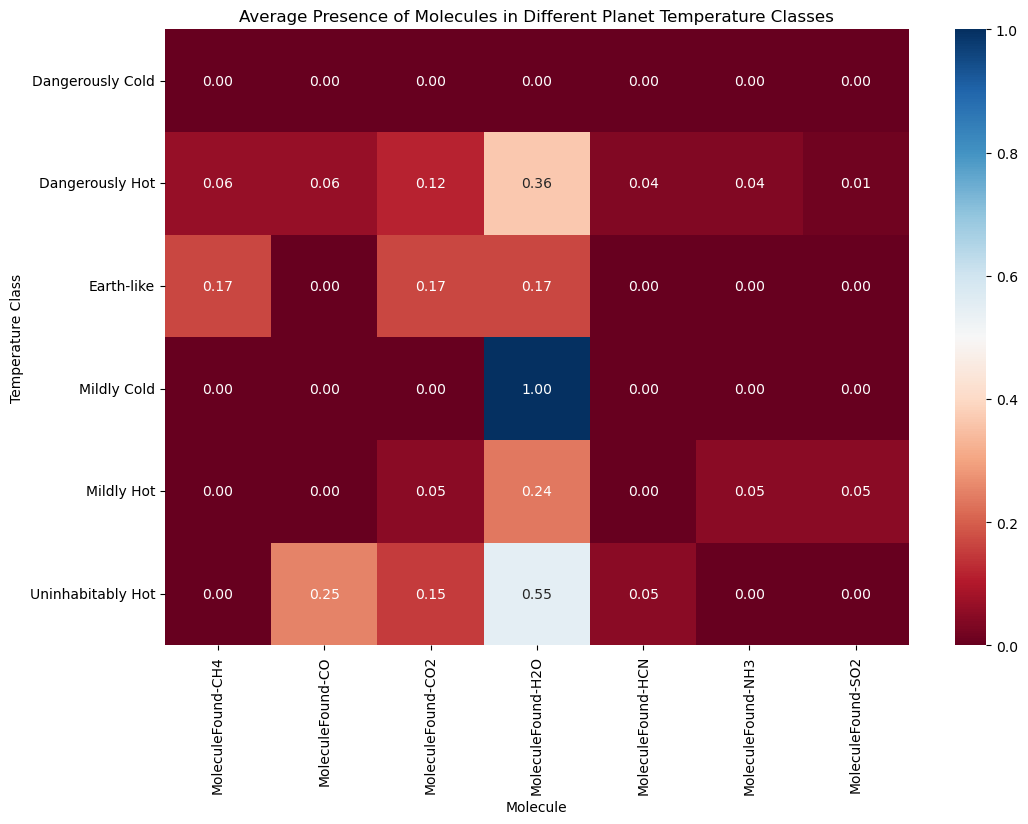

In [186]:
pivotTable = meltedDF.pivot_table(index='TemperatureClass', columns= 'Molecule', aggfunc='mean')

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivotTable, cmap="RdBu", annot=True, fmt=".2f", cbar=True)
plt.title('Average Presence of Molecules in Different Planet Temperature Classes')
plt.xlabel('Molecule')
plt.ylabel('Temperature Class')
plt.show()

The heatmap shows the average presence of molecules in different temperature classes.
According to the heatmap, CH4 is infrequently found on Dangerously Hot and Earth-like exoplanets only, CO is very infrequently found in Dangerously Hot exoplanets but found often in Uninhabitably Hot planets, CO2 is infrequently found in Uninhabitably Hot, Mildly Hot,   , H2O  , HCN  , NH3  , SO2

# Habitability Visualisations

Calculating the habitability score with the addition of the molucles column to determine the most habitable planets with atmospheric compesitions suitable to sustain life.  

In [187]:
def convertMagnitude(row):
    G = row['StellarBrightnessGaia']
    d = row['DistancetoPlanetarySystem']
    M = G - 5 * math.log10(d) + 5
    
    return M

cleanedDF['StellarAbsoluteMagnitude'] = cleanedDF.apply(convertMagnitude, axis=1)


C:\Users\USER\AppData\Local\Temp\ipykernel_11476\690955711.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [188]:
cleanedDF.head()

,PlanetName,PlanetType,Molecules,Molecules_Detection,H2O,CH4,CO2,NH3,CO,SO2,...,StellarBrightnessGaia,PlanetMass,StellarMass,PlanetRadiusKm,StellarRadiusKm,PlanetGravity,StellarVolume,StellarDensity,TemperatureClass,StellarAbsoluteMagnitude
0,55 Cnc e,Hot Super-Earth,Ca+ Ca Fe+ Fe H H HCN He He K Mg Na,No Detection,0,0,0,0,0,0,...,5.72973,4.771948e+25,1.809535e+30,11945.625,653958.0,2.231946e+07,1.171489e+18,1.544645e+12,Dangerously Hot,5.230378
3,AU Mic b,Warm Neptune,H H He,No Detection,0,0,0,0,0,0,...,7.84038,1.012508e+30,1.014135e+30,25210.047,514818.0,1.063303e+11,5.715441e+17,1.774377e+12,Mildly Hot,7.901580
4,CoRoT-1 b,Hot Jupiter,Featureless spectra H H2O Rayleigh Scattering VO,"Featureless spectra, H2O, Rayleigh Scattering, VO",1,0,0,0,0,0,...,13.45700,1.955065e+27,1.889075e+30,106395.700,772227.0,1.152707e+07,1.928961e+18,9.793223e+11,Dangerously Hot,3.974620
5,GJ 436 b,Warm Neptune,FeH H H He,H,0,0,0,0,0,0,...,9.57148,1.516990e+26,1.113560e+30,26121.100,320022.0,1.483903e+07,1.372866e+17,8.111207e+12,Mildly Hot,9.625742
6,GJ 1214 b,Warm Sub-Neptune,Featureless spectra He He He,"Featureless spectra, He",0,0,0,0,0,0,...,13.00890,5.022788e+25,3.579300e+29,17411.943,153054.0,1.105748e+07,1.501837e+16,2.383282e+13,Mildly Hot,12.180794


In [189]:
from math import pi
def calcLuminosity(row):
    M = row['StellarAbsoluteMagnitude']
    d = row['DistancetoPlanetarySystem']
    L = 4 * pi * (d*d) * 10 * (-0.4*M)
    
    return L

cleanedDF['StellarLuminosity'] = cleanedDF.apply(calcLuminosity, axis=1)



C:\Users\USER\AppData\Local\Temp\ipykernel_11476\2573082077.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [190]:
cleanedDF.head()

,PlanetName,PlanetType,Molecules,Molecules_Detection,H2O,CH4,CO2,NH3,CO,SO2,...,PlanetMass,StellarMass,PlanetRadiusKm,StellarRadiusKm,PlanetGravity,StellarVolume,StellarDensity,TemperatureClass,StellarAbsoluteMagnitude,StellarLuminosity
0,55 Cnc e,Hot Super-Earth,Ca+ Ca Fe+ Fe H H HCN He He K Mg Na,No Detection,0,0,0,0,0,0,...,4.771948e+25,1.809535e+30,11945.625,653958.0,2.231946e+07,1.171489e+18,1.544645e+12,Dangerously Hot,5.230378,-4.164318e+04
3,AU Mic b,Warm Neptune,H H He,No Detection,0,0,0,0,0,0,...,1.012508e+30,1.014135e+30,25210.047,514818.0,1.063303e+11,5.715441e+17,1.774377e+12,Mildly Hot,7.901580,-3.754084e+04
4,CoRoT-1 b,Hot Jupiter,Featureless spectra H H2O Rayleigh Scattering VO,"Featureless spectra, H2O, Rayleigh Scattering, VO",1,0,0,0,0,0,...,1.955065e+27,1.889075e+30,106395.700,772227.0,1.152707e+07,1.928961e+18,9.793223e+11,Dangerously Hot,3.974620,-1.240274e+08
5,GJ 436 b,Warm Neptune,FeH H H He,H,0,0,0,0,0,0,...,1.516990e+26,1.113560e+30,26121.100,320022.0,1.483903e+07,1.372866e+17,8.111207e+12,Mildly Hot,9.625742,-4.602558e+04
6,GJ 1214 b,Warm Sub-Neptune,Featureless spectra He He He,"Featureless spectra, He",0,0,0,0,0,0,...,5.022788e+25,3.579300e+29,17411.943,153054.0,1.105748e+07,1.501837e+16,2.383282e+13,Mildly Hot,12.180794,-1.312767e+05


In [191]:
def lowerBound(row):
    LB = ((row['StellarLuminosity'] / (3.846 * (10**26)))**0.5) * 0.95
    
    return LB

def upperBound(row):
    UB = ((row['StellarLuminosity'] / (3.846 * (10**26)))**0.5) * 1.37
    
    return UB

In [192]:
cleanedDF['HabitableZoneLB'] = cleanedDF.apply(lowerBound, axis=1)
cleanedDF['HabitableZoneUB'] = cleanedDF.apply(upperBound, axis=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_11476\840858980.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_11476\840858980.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [193]:
cleanedDF.head()

,PlanetName,PlanetType,Molecules,Molecules_Detection,H2O,CH4,CO2,NH3,CO,SO2,...,PlanetRadiusKm,StellarRadiusKm,PlanetGravity,StellarVolume,StellarDensity,TemperatureClass,StellarAbsoluteMagnitude,StellarLuminosity,HabitableZoneLB,HabitableZoneUB
0,55 Cnc e,Hot Super-Earth,Ca+ Ca Fe+ Fe H H HCN He He K Mg Na,No Detection,0,0,0,0,0,0,...,11945.625,653958.0,2.231946e+07,1.171489e+18,1.544645e+12,Dangerously Hot,5.230378,-4.164318e+04,6.053015e-28+9.885324e- 12j,8.729085e-28+1.425568e- 11j
3,AU Mic b,Warm Neptune,H H He,No Detection,0,0,0,0,0,0,...,25210.047,514818.0,1.063303e+11,5.715441e+17,1.774377e+12,Mildly Hot,7.901580,-3.754084e+04,5.747140e-28+9.385792e- 12j,8.287981e-28+1.353530e- 11j
4,CoRoT-1 b,Hot Jupiter,Featureless spectra H H2O Rayleigh Scattering VO,"Featureless spectra, H2O, Rayleigh Scattering, VO",1,0,0,0,0,0,...,106395.700,772227.0,1.152707e+07,1.928961e+18,9.793223e+11,Dangerously Hot,3.974620,-1.240274e+08,3.303380e-26+5.394830e- 10j,4.763822e-26+7.779912e- 10j
5,GJ 436 b,Warm Neptune,FeH H H He,H,0,0,0,0,0,0,...,26121.100,320022.0,1.483903e+07,1.372866e+17,8.111207e+12,Mildly Hot,9.625742,-4.602558e+04,6.363550e-28+1.039247e- 11j,9.176908e-28+1.498703e- 11j
6,GJ 1214 b,Warm Sub-Neptune,Featureless spectra He He He,"Featureless spectra, He",0,0,0,0,0,0,...,17411.943,153054.0,1.105748e+07,1.501837e+16,2.383282e+13,Mildly Hot,12.180794,-1.312767e+05,1.074716e-27+1.755144e- 11j,1.549854e-27+2.531103e- 11j


In [194]:
def habitibilityScore(row):
    score = 0
    LB = float(row['HabitableZoneLB'].real)
    UB = float(row['HabitableZoneUB'].real)
    if 0.0034 <= row['Eccentricity'] <= 0.058:
        score += 1
    if 0.5 <= row['OrbitSemi-MajorAxis'] <= 1.52:
        score += 1
    if 255 <= row['EquilibriumTemperature'] <= 288:
        score += 1
    if LB <= row['DistancetoPlanetarySystem'] <= UB:
        score += 1
    if 0.2 <= row['PlanetGravity'] <= 4.6:
        score += 1
        
    return score

cleanedDF['Habitability'] = cleanedDF.apply(habitibilityScore, axis=1)


C:\Users\USER\AppData\Local\Temp\ipykernel_11476\3512390201.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [195]:
cleanedDF.head()

,PlanetName,PlanetType,Molecules,Molecules_Detection,H2O,CH4,CO2,NH3,CO,SO2,...,StellarRadiusKm,PlanetGravity,StellarVolume,StellarDensity,TemperatureClass,StellarAbsoluteMagnitude,StellarLuminosity,HabitableZoneLB,HabitableZoneUB,Habitability
0,55 Cnc e,Hot Super-Earth,Ca+ Ca Fe+ Fe H H HCN He He K Mg Na,No Detection,0,0,0,0,0,0,...,653958.0,2.231946e+07,1.171489e+18,1.544645e+12,Dangerously Hot,5.230378,-4.164318e+04,6.053015e-28+9.885324e- 12j,8.729085e-28+1.425568e- 11j,1
3,AU Mic b,Warm Neptune,H H He,No Detection,0,0,0,0,0,0,...,514818.0,1.063303e+11,5.715441e+17,1.774377e+12,Mildly Hot,7.901580,-3.754084e+04,5.747140e-28+9.385792e- 12j,8.287981e-28+1.353530e- 11j,1
4,CoRoT-1 b,Hot Jupiter,Featureless spectra H H2O Rayleigh Scattering VO,"Featureless spectra, H2O, Rayleigh Scattering, VO",1,0,0,0,0,0,...,772227.0,1.152707e+07,1.928961e+18,9.793223e+11,Dangerously Hot,3.974620,-1.240274e+08,3.303380e-26+5.394830e- 10j,4.763822e-26+7.779912e- 10j,0
5,GJ 436 b,Warm Neptune,FeH H H He,H,0,0,0,0,0,0,...,320022.0,1.483903e+07,1.372866e+17,8.111207e+12,Mildly Hot,9.625742,-4.602558e+04,6.363550e-28+1.039247e- 11j,9.176908e-28+1.498703e- 11j,0
6,GJ 1214 b,Warm Sub-Neptune,Featureless spectra He He He,"Featureless spectra, He",0,0,0,0,0,0,...,153054.0,1.105748e+07,1.501837e+16,2.383282e+13,Mildly Hot,12.180794,-1.312767e+05,1.074716e-27+1.755144e- 11j,1.549854e-27+2.531103e- 11j,1


In [196]:
Habitabledf = cleanedDF.copy()
def newHabitibilityScore(row):
    score = 0
    desired_molecules = ['H2O', 'CH4', 'CO2','NH3']
    # Check for required molecules
    for molecule in desired_molecules:
        if row[molecule] == 1:
            score += 1

    # Check for toxic molecules (subtract from score)
    toxic_molecules = ['SO2','CO','HCN']  # Add toxic molecule names here
    for molecule in toxic_molecules:
        if row[molecule] == 1:
            score -= 0.5
        
    return score

Habitabledf['Habitability'] = cleanedDF.apply(newHabitibilityScore, axis=1)

In [197]:
hdf = Habitabledf.where(Habitabledf["Habitability"] > 1)
hdf = hdf.dropna()
hdf = hdf.sort_values(by='Habitability')
hdf.head()

,PlanetName,PlanetType,Molecules,Molecules_Detection,H2O,CH4,CO2,NH3,CO,SO2,...,StellarRadiusKm,PlanetGravity,StellarVolume,StellarDensity,TemperatureClass,StellarAbsoluteMagnitude,StellarLuminosity,HabitableZoneLB,HabitableZoneUB,Habitability
184,WASP-43 b,Hot Jupiter,AlO CH4 CO CO2 Cloudy H2O Molecular ratios: C/...,"AlO, CO, CO2, Cloudy, H2O, Molecular ratios: C...",1.0,0.0,1.0,0.0,1.0,0.0,...,452205.0,4.904781e+07,3.873421e+17,3.542256e+12,Dangerously Hot,7.215735,-2.729332e+06,4.900360e-27+8.002896e- 11j,7.066835e-27+1.154102e- 10j,1.5
171,WASP-17 b,Hot Jupiter,AlO CO2 H2O K K Na Na SO2,"AlO, CO2, H2O, K, Na, SO2",1.0,0.0,1.0,0.0,0.0,1.0,...,1036593.0,5.541214e+06,4.665664e+18,9.717331e+11,Dangerously Hot,3.338162,-2.764601e+07,1.559610e-26+2.547037e- 10j,2.249122e-26+3.673095e- 10j,1.5
19,HAT-P-7 b,UltraHot Jupiter,CO2 FeH H2O,"CO2, FeH, H2O",1.0,0.0,1.0,0.0,0.0,0.0,...,1384443.0,1.847634e+10,1.111511e+19,2.719289e+11,Uninhabitably Hot,2.701125,-1.579518e+07,1.178860e-26+1.925224e- 10j,1.700040e-26+2.776375e- 10j,2.0
200,WASP-74 b,Hot Jupiter,CH4 CH4 Featureless spectra H2O H2O Rayleigh S...,"CH4, Featureless spectra, H2O, Rayleigh Scatte...",1.0,1.0,0.0,0.0,0.0,0.0,...,1140948.0,9.697883e+06,6.221372e+18,4.730436e+11,Dangerously Hot,3.703223,-4.144580e+06,6.038653e-27+9.861869e- 11j,8.708373e-27+1.422185e- 10j,2.0
168,WASP-12 b,UltraHot Jupiter,CO2 Fe+ Featureless spectra H H2O He He Mg+ Na...,"CO2, Fe+, Featureless spectra, H, H2O, Mg+, Na",1.0,0.0,1.0,0.0,0.0,0.0,...,1092249.0,1.058672e+07,5.458252e+18,4.918195e+11,Uninhabitably Hot,3.346510,-3.070563e+07,1.643648e-26+2.684281e- 10j,2.370313e-26+3.871016e- 10j,2.0


<Axes: xlabel='PlanetName', ylabel='Habitability'>

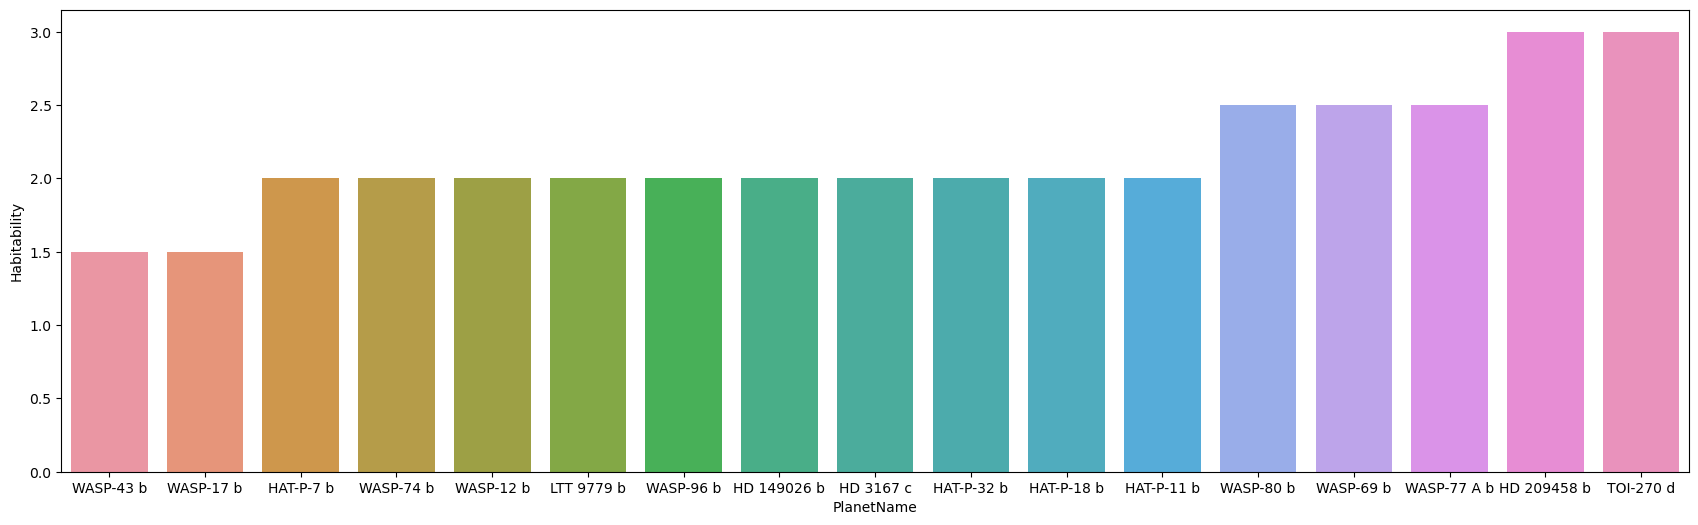

In [198]:
plt.figure(figsize=(21, 6))
sns.barplot(data = hdf,x = "PlanetName", y= "Habitability")

From this bar chart, we can conclude that most of the planets considered most habitable had a habitability score of 2, with the exception of TOI-270 d which we can claim is considered the most habitable planet based on our calculatuions and findings.

# Hypothesis Testing

## Chi-Square on Discovery Year and Discovery Method columns

#### Question: Is there a relationship between discovery method and the discovery year of exoplanets

H0 = The discovery method of and exoplanet is independant of the year of its discovery, at 0.1% significance level.

H1 = The discovery method of and exoplanet is dependant on the year of its discovery, at 0.1% significance level.

In [199]:
cleanedDF["DiscoveryYear"] = cleanedDF["DiscoveryYear"].astype(str)

C:\Users\USER\AppData\Local\Temp\ipykernel_11476\3879387349.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [200]:
htDF = cleanedDF[["DiscoveryMethod","DiscoveryYear"]]
htDF.head()

,DiscoveryMethod,DiscoveryYear
0,Radial Velocity,2004
3,Transit,2020
4,Transit,2008
5,Radial Velocity,2004
6,Transit,2009


In [201]:
htDF["DiscoveryYear"].unique()

array(['2004', '2020', '2008', '2009', '2012', '2017', '2006', '2007',
       '2010', '2011', '2014', '2015', '2016', '2019', '2018', '2022',
       '2005', '1999', '2013', '2021', '2023'], dtype=object)

In [202]:
htDF["DiscoveryMethod"].unique()

array(['Radial Velocity', 'Transit'], dtype=object)

In [203]:
rows=htDF['DiscoveryYear'].unique()
cols=htDF['DiscoveryMethod'].unique()

Collecting Observed Frequency

In [204]:
## Counting the values
matrix=[]
for i in rows:
    l=[]
    for j in cols:
        l.append(len(htDF[(htDF['DiscoveryYear']==i) & (htDF['DiscoveryMethod']==j)]))
    matrix.append(l)
matrix

[[2, 0],
 [0, 9],
 [0, 6],
 [0, 7],
 [1, 11],
 [0, 12],
 [0, 2],
 [0, 4],
 [1, 10],
 [0, 7],
 [0, 11],
 [0, 6],
 [0, 9],
 [0, 8],
 [0, 4],
 [0, 6],
 [2, 0],
 [1, 0],
 [0, 3],
 [0, 3],
 [0, 2]]

In [205]:
#Observed Frequency
htDF = pd.DataFrame(matrix,index=rows,columns=cols)
htDF.head()

,Radial Velocity,Transit
2004,2,0
2020,0,9
2008,0,6
2009,0,7
2012,1,11


In [206]:
#Find sum to calculate total of each row and column
htDF.sum()

Radial Velocity      7
Transit            120
dtype: int64

In [207]:
#Calculating total for columns
htDF.loc['Total'] = htDF.sum()

In [208]:
htDF

,Radial Velocity,Transit
2004,2,0
2020,0,9
2008,0,6
2009,0,7
2012,1,11
2017,0,12
2006,0,2
2007,0,4
2010,1,10
2011,0,7


In [209]:
#Calculate Total for rows
htDF['Total']=htDF.sum(axis=1)

In [210]:
htDF

,Radial Velocity,Transit,Total
2004,2,0,2
2020,0,9,9
2008,0,6,6
2009,0,7,7
2012,1,11,12
2017,0,12,12
2006,0,2,2
2007,0,4,4
2010,1,10,11
2011,0,7,7


## Expected Frequency

Expected Frequency = (Row Total * Column Total) / Grand Total

In [211]:
matrix=[]
for i in rows:
    l=[]
    for j in cols:
        print(htDF.loc[i,'Total'])
        print(htDF.loc['Total',j])
        print(htDF.loc['Total','Total'])
        break
    break

2
7
127


In [212]:
#Calculating Expected Cell Frequencies
matrix=[]
for i in rows:
    l=[]
    for j in cols:
        v=(htDF.loc[i,'Total']*htDF.loc['Total',j])/htDF.loc['Total','Total']
        l.append(v)
    matrix.append(l)
matrix

[[0.11023622047244094, 1.889763779527559],
 [0.49606299212598426, 8.503937007874017],
 [0.33070866141732286, 5.669291338582677],
 [0.3858267716535433, 6.6141732283464565],
 [0.6614173228346457, 11.338582677165354],
 [0.6614173228346457, 11.338582677165354],
 [0.11023622047244094, 1.889763779527559],
 [0.2204724409448819, 3.779527559055118],
 [0.6062992125984252, 10.393700787401574],
 [0.3858267716535433, 6.6141732283464565],
 [0.6062992125984252, 10.393700787401574],
 [0.33070866141732286, 5.669291338582677],
 [0.49606299212598426, 8.503937007874017],
 [0.4409448818897638, 7.559055118110236],
 [0.2204724409448819, 3.779527559055118],
 [0.33070866141732286, 5.669291338582677],
 [0.11023622047244094, 1.889763779527559],
 [0.05511811023622047, 0.9448818897637795],
 [0.16535433070866143, 2.8346456692913384],
 [0.16535433070866143, 2.8346456692913384],
 [0.11023622047244094, 1.889763779527559]]

In [213]:
#Replace values with Expected Frequencies
expectedHTDF=pd.DataFrame(matrix,index=rows,columns=cols)
expectedHTDF

,Radial Velocity,Transit
2004,0.110236,1.889764
2020,0.496063,8.503937
2008,0.330709,5.669291
2009,0.385827,6.614173
2012,0.661417,11.338583
2017,0.661417,11.338583
2006,0.110236,1.889764
2007,0.220472,3.779528
2010,0.606299,10.393701
2011,0.385827,6.614173


In [214]:
htDF.drop('Total',axis=1,inplace=True)
htDF.drop('Total',axis=0,inplace=True)

In [215]:
htDF

,Radial Velocity,Transit
2004,2,0
2020,0,9
2008,0,6
2009,0,7
2012,1,11
2017,0,12
2006,0,2
2007,0,4
2010,1,10
2011,0,7


## Degrees Of Freedom

Degree of Freedom = (r - 1) (c - 1)

In [216]:
expectedHTDF.shape

(21, 2)

In [217]:
freedomHTDF = (expectedHTDF.shape[0] - 1) * (expectedHTDF.shape[1] - 1)
freedomHTDF

20

## Chi-Square Calculation

x^2 = Ʃ(Observed Frequency - Expected Frequency)^2 / Expected Frequency

In [218]:
htDF.values.flatten()

array([ 2,  0,  0,  9,  0,  6,  0,  7,  1, 11,  0, 12,  0,  2,  0,  4,  1,
       10,  0,  7,  0, 11,  0,  6,  0,  9,  0,  8,  0,  4,  0,  6,  2,  0,
        1,  0,  0,  3,  0,  3,  0,  2], dtype=int64)

In [219]:
chiScoreTable = pd.DataFrame(htDF.values.flatten(),columns=['O'])
chiScoreTable

,O
0,2
1,0
2,0
3,9
4,0
5,6
6,0
7,7
8,1
9,11


In [220]:
## Expected value
chiScoreTable['E']=expectedHTDF.values.flatten()
chiScoreTable

,O,E
0,2,0.110236
1,0,1.889764
2,0,0.496063
3,9,8.503937
4,0,0.330709
5,6,5.669291
6,0,0.385827
7,7,6.614173
8,1,0.661417
9,11,11.338583


In [221]:
## Calculating O-E
chiScoreTable['O-E']=chiScoreTable['O']-chiScoreTable['E']
chiScoreTable

,O,E,O-E
0,2,0.110236,1.889764
1,0,1.889764,-1.889764
2,0,0.496063,-0.496063
3,9,8.503937,0.496063
4,0,0.330709,-0.330709
5,6,5.669291,0.330709
6,0,0.385827,-0.385827
7,7,6.614173,0.385827
8,1,0.661417,0.338583
9,11,11.338583,-0.338583


In [222]:
## Calculating (O-E)^2
chiScoreTable['(O-E)^2']=chiScoreTable['O-E']**2
chiScoreTable

,O,E,O-E,(O-E)^2
0,2,0.110236,1.889764,3.571207
1,0,1.889764,-1.889764,3.571207
2,0,0.496063,-0.496063,0.246078
3,9,8.503937,0.496063,0.246078
4,0,0.330709,-0.330709,0.109368
5,6,5.669291,0.330709,0.109368
6,0,0.385827,-0.385827,0.148862
7,7,6.614173,0.385827,0.148862
8,1,0.661417,0.338583,0.114638
9,11,11.338583,-0.338583,0.114638


In [223]:
## Calculating ((O-E)^2)\E
chiScoreTable['((O-E)^2)\E']=chiScoreTable['(O-E)^2']/chiScoreTable['E']
chiScoreTable

,O,E,O-E,(O-E)^2,((O-E)^2)\E
0,2,0.110236,1.889764,3.571207,32.395951
1,0,1.889764,-1.889764,3.571207,1.889764
2,0,0.496063,-0.496063,0.246078,0.496063
3,9,8.503937,0.496063,0.246078,0.028937
4,0,0.330709,-0.330709,0.109368,0.330709
5,6,5.669291,0.330709,0.109368,0.019291
6,0,0.385827,-0.385827,0.148862,0.385827
7,7,6.614173,0.385827,0.148862,0.022507
8,1,0.661417,0.338583,0.114638,0.173322
9,11,11.338583,-0.338583,0.114638,0.010110


In [224]:
#Finding sum of last column to get the Chi Score
chiScore = chiScoreTable['((O-E)^2)\E'].sum()
chiScore

91.94328102453102

If the chi square statistic exceeds the probability or table value (based upon a p-value of x and n degrees of freedom) the null hypothesis should be rejected.

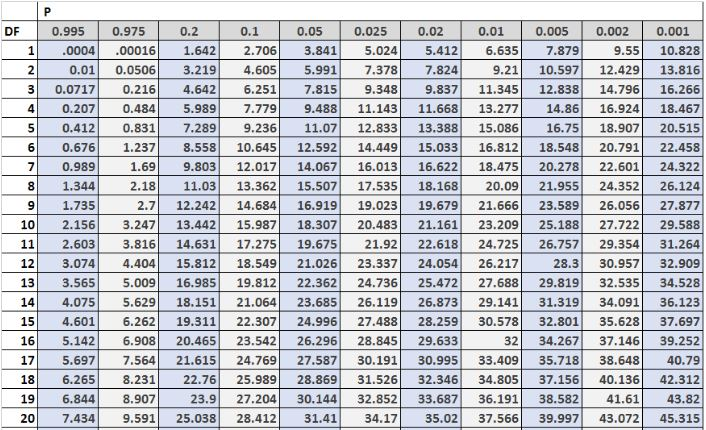

Chi Square (Observed statistic) = 91.94328102453102

Probability Level (defOfFreedom = 20 and Significance = .001) = 45.315 (Table Value)

So, Chi Square statistic > Probability Level (Table Value)

### REJECT NULL HYPOTHESIS

There is a significant difference between discovery method and discovery year, therefore, they are dependant on each other. 
The difference is statistically significant, so this means that there is strong evidence to suggest a dependancy between the features.